# Import librerie

Import delle librerie e del dataset

In [2]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import scipy.stats as stats 
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import rpy2

# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/Progetto SDMTSA/data2022_train.csv"
data = pd.read_csv(path)

In [5]:
print(data.head())

            Unnamed: 0            y
0  2017-01-01 00:00:00  34055.69620
1  2017-01-01 00:10:00  29814.68354
2  2017-01-01 00:20:00  29128.10127
3  2017-01-01 00:30:00  28228.86076
4  2017-01-01 00:40:00  27335.69620


# Pre-processing

Cambio il nome alle colonne

In [6]:
data = data.rename(columns = {'Unnamed: 0':'Date', 'y':'Value'}, inplace = False)

In [7]:
print(data.head())

                  Date        Value
0  2017-01-01 00:00:00  34055.69620
1  2017-01-01 00:10:00  29814.68354
2  2017-01-01 00:20:00  29128.10127
3  2017-01-01 00:30:00  28228.86076
4  2017-01-01 00:40:00  27335.69620


## Valori nulli e/o duplicati

Vediamo se ci sono valori nulli e/o valori NA e/o valori duplicati.

In [8]:
print(data['Value'].isnull())

0        False
1        False
2        False
3        False
4        False
         ...  
48091    False
48092    False
48093    False
48094    False
48095    False
Name: Value, Length: 48096, dtype: bool


In [9]:
print(data.isnull().sum())

Date     0
Value    0
dtype: int64


In [10]:
print(sum(data.duplicated()))

0


In [11]:
data.isnull().values.any()

False

In [12]:
data.isna().any(axis=None)

False

Non ci sono missing values, né valori NA, né valori mancanti.

## Manipolazione della data e creazione di colonne aggiuntive

Trasformo la colonna Date in datetime

In [13]:
data['Date'] = pd.to_datetime(data['Date'])

In [14]:
print(data.head())

                 Date        Value
0 2017-01-01 00:00:00  34055.69620
1 2017-01-01 00:10:00  29814.68354
2 2017-01-01 00:20:00  29128.10127
3 2017-01-01 00:30:00  28228.86076
4 2017-01-01 00:40:00  27335.69620


Faccio una divisione della data in: anno, giorno, mese, ora, minuti, secondi

In [15]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Day'] = data.Date.dt.day
data['Hour'] = data.Date.dt.hour
data['Minute'] = data.Date.dt.minute
data['Second'] = data.Date.dt.second
data['WeekDay'] = data.Date.dt.day_name()
data['Month_Name'] = data.Date.dt.strftime("%B")

data['Num_DayofYear'] = data['Date'].dt.dayofyear
data['Num_DayofWeek'] = data['Date'].dt.dayofweek
data['Num_WeekofYear'] = data['Date'].dt.isocalendar().week

data['Quarter'] = data['Date'].dt.quarter

data['Just_Date'] = data['Date'].dt.date

Set della data comoleta come index

In [16]:
data.set_index(data['Date'], inplace = True)

In [17]:
data = data.drop(['Date'], axis = 1)
data['Month_Name'] = data.index.strftime("%B")

In [18]:
print(data.head())

                           Value  Year  Month  Day  Hour  Minute  Second  \
Date                                                                       
2017-01-01 00:00:00  34055.69620  2017      1    1     0       0       0   
2017-01-01 00:10:00  29814.68354  2017      1    1     0      10       0   
2017-01-01 00:20:00  29128.10127  2017      1    1     0      20       0   
2017-01-01 00:30:00  28228.86076  2017      1    1     0      30       0   
2017-01-01 00:40:00  27335.69620  2017      1    1     0      40       0   

                    WeekDay Month_Name  Num_DayofYear  Num_DayofWeek  \
Date                                                                   
2017-01-01 00:00:00  Sunday    January              1              6   
2017-01-01 00:10:00  Sunday    January              1              6   
2017-01-01 00:20:00  Sunday    January              1              6   
2017-01-01 00:30:00  Sunday    January              1              6   
2017-01-01 00:40:00  Sunday    Janu

In [19]:
print(data)

                           Value  Year  Month  Day  Hour  Minute  Second  \
Date                                                                       
2017-01-01 00:00:00  34055.69620  2017      1    1     0       0       0   
2017-01-01 00:10:00  29814.68354  2017      1    1     0      10       0   
2017-01-01 00:20:00  29128.10127  2017      1    1     0      20       0   
2017-01-01 00:30:00  28228.86076  2017      1    1     0      30       0   
2017-01-01 00:40:00  27335.69620  2017      1    1     0      40       0   
...                          ...   ...    ...  ...   ...     ...     ...   
2017-11-30 23:10:00  31347.69231  2017     11   30    23      10       0   
2017-11-30 23:20:00  30603.07692  2017     11   30    23      20       0   
2017-11-30 23:30:00  29889.23077  2017     11   30    23      30       0   
2017-11-30 23:40:00  29249.23077  2017     11   30    23      40       0   
2017-11-30 23:50:00  28584.61538  2017     11   30    23      50       0   

           

# Analisi Esplorativa

## Rappresentazioni per granularità della serie

Serie storica vista nella sua totalità.

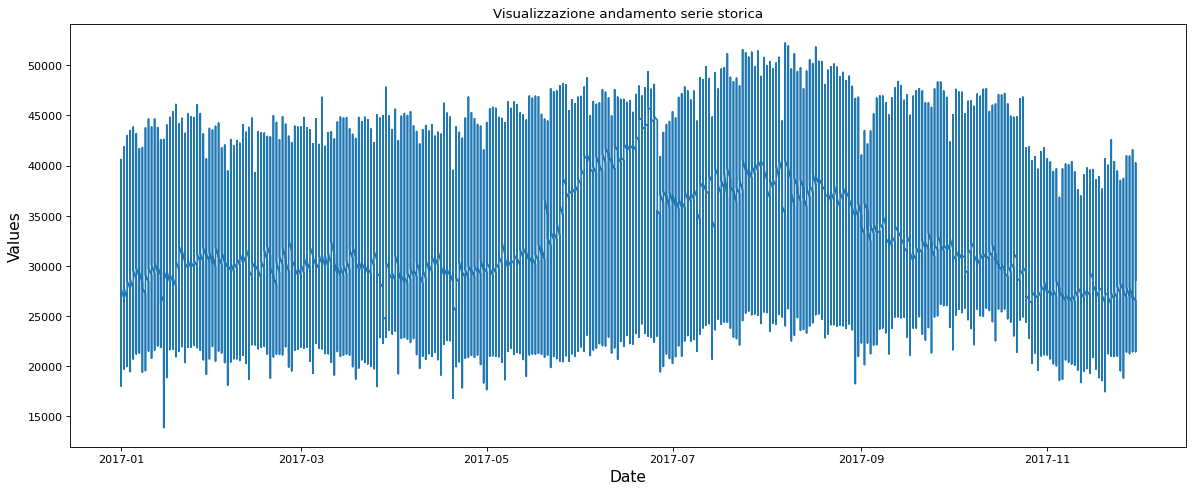

In [20]:
figure(figsize=(18, 7), dpi=80, linewidth=10)
plt.plot(data['Just_Date'], data['Value'])
plt.title('Visualizzazione andamento serie storica')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.show()

Serie storica vista nella sua totalità, ma con granularità GIORNALIERA.

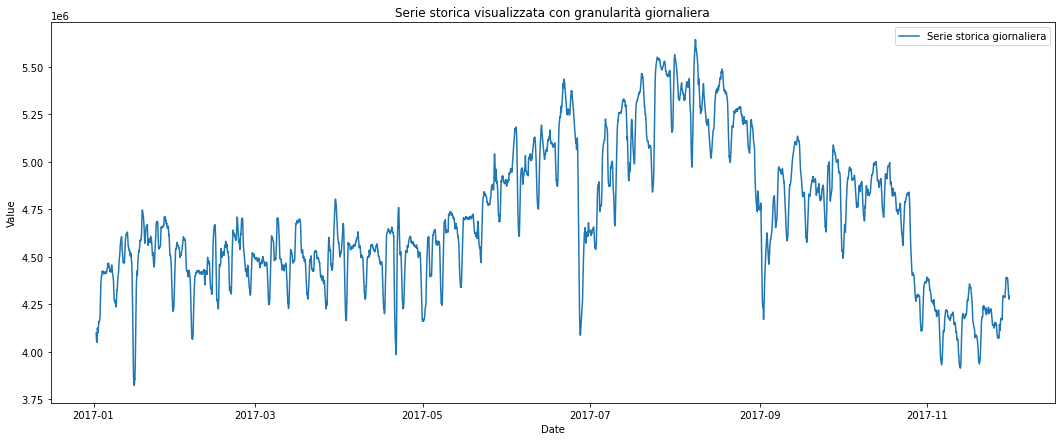

In [21]:
# Calcolo la media rolling giornaliera della serie storica
serie_giorn = data['Value'].rolling(window=144).sum() #144 è 24*6 quindi un giorno 
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_giorn, label="Serie storica giornaliera")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità giornaliera")
plt.legend()
plt.show()

Serie storica vista nella sua totalità, ma con granularità SETTIMANALE.

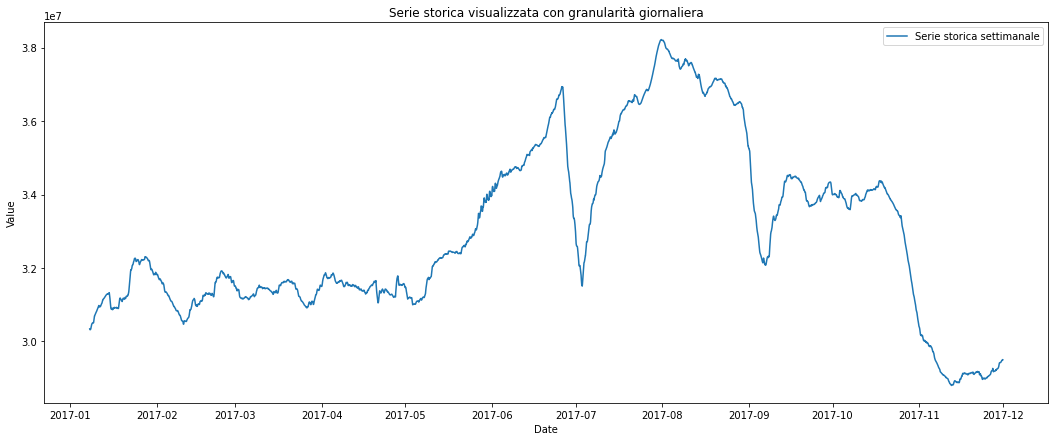

In [22]:
# Calcolo la media rolling giornaliera della serie storica
serie_sett = data['Value'].rolling(window=1008).sum() #1008 settimanale, 6*24*7
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_sett, label="Serie storica settimanale")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità giornaliera")
plt.legend()
plt.show()

Serie storica vista nella sua totalità, ma con granularità MENSILE.

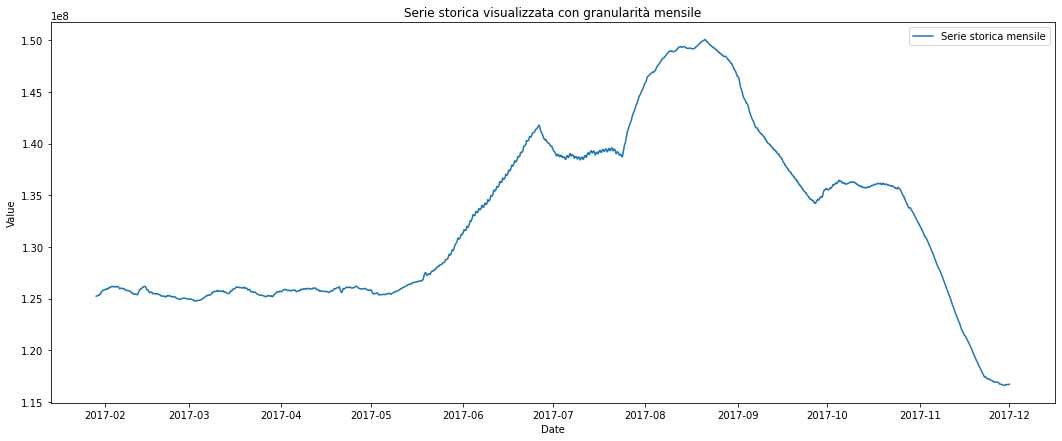

In [23]:
# Calcolo la media rolling giornaliera della serie storica
serie_mensile = data['Value'].rolling(window=4032).sum() # 4032 mensile, 6*24*7*4
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_mensile, label="Serie storica mensile")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità mensile")
plt.legend()
plt.show()

## Altre analisi

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


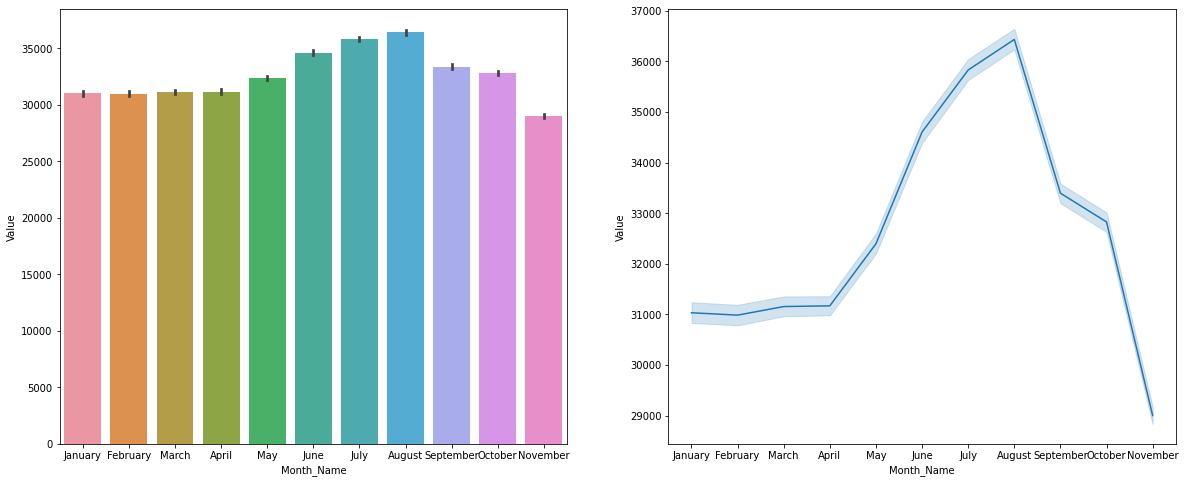

In [24]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Month_Name'], data['Value'], ax = ax[0])
sns.lineplot(data['Month_Name'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


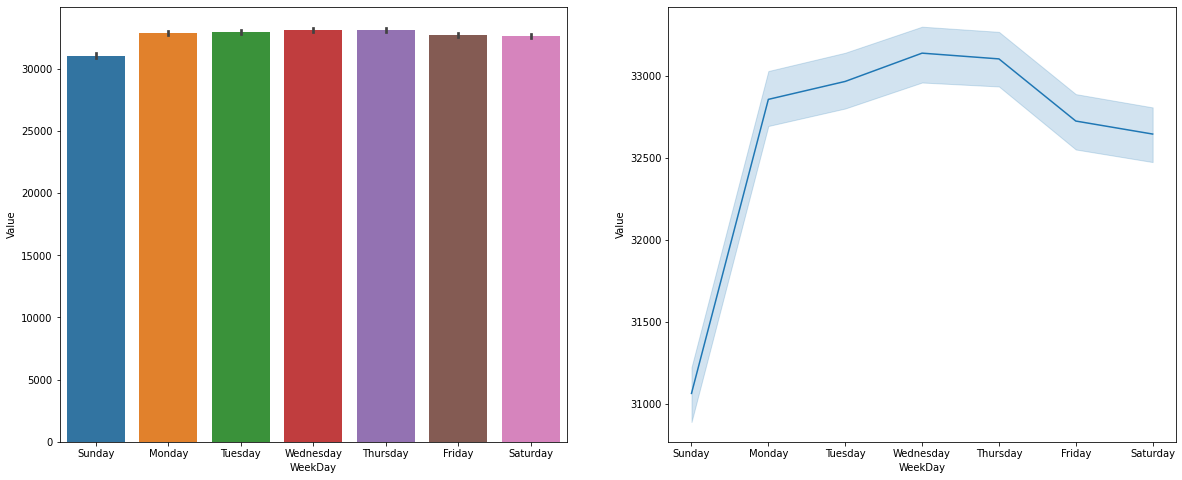

In [25]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['WeekDay'], data['Value'], ax = ax[0])
sns.lineplot(data['WeekDay'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


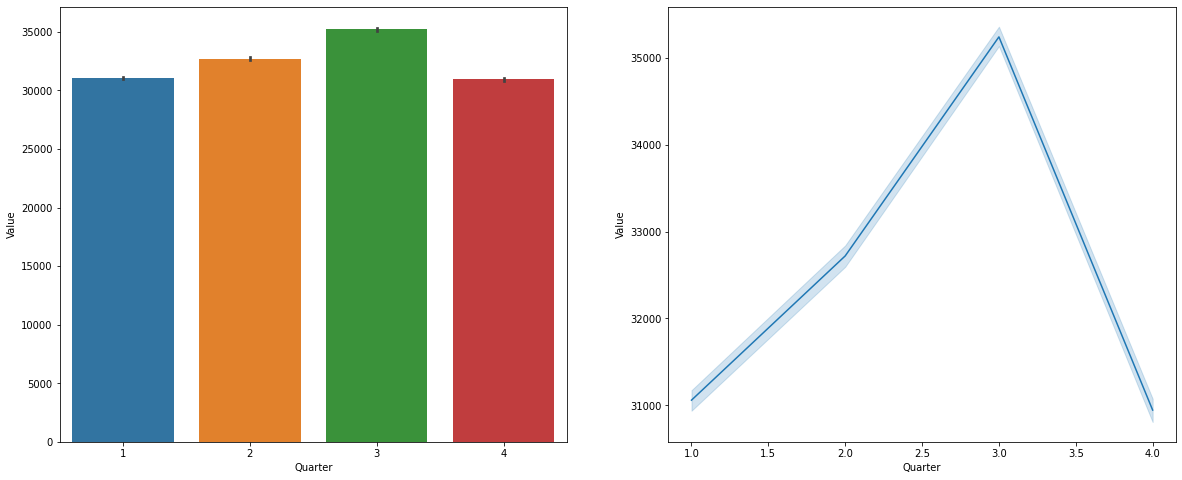

In [26]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Quarter'], data['Value'], ax = ax[0])
sns.lineplot(data['Quarter'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


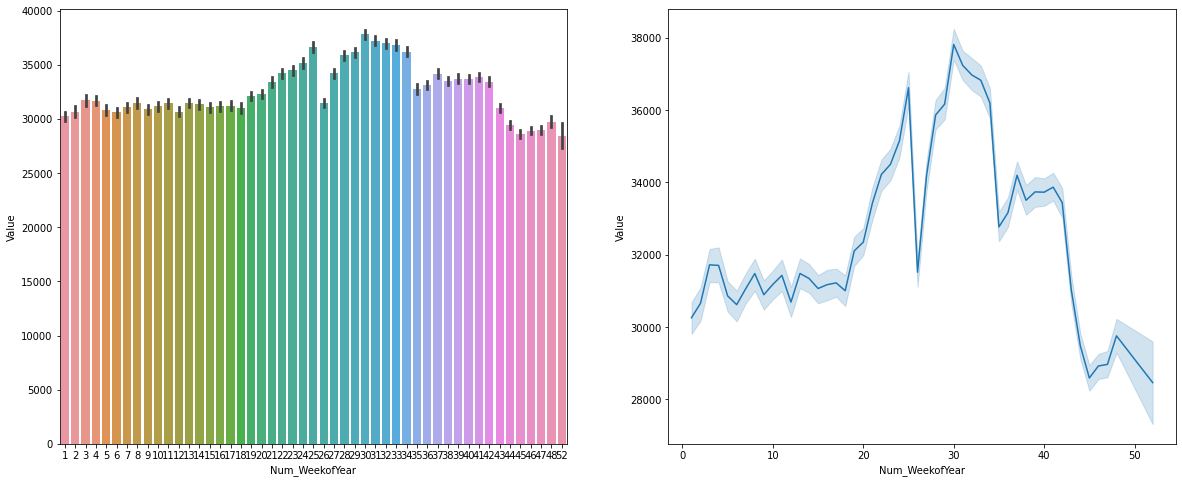

In [27]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Num_WeekofYear'], data['Value'], ax = ax[0])
sns.lineplot(data['Num_WeekofYear'], data['Value'], ax = ax[1])

### Andamento in funzione dell'ora del giorno

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


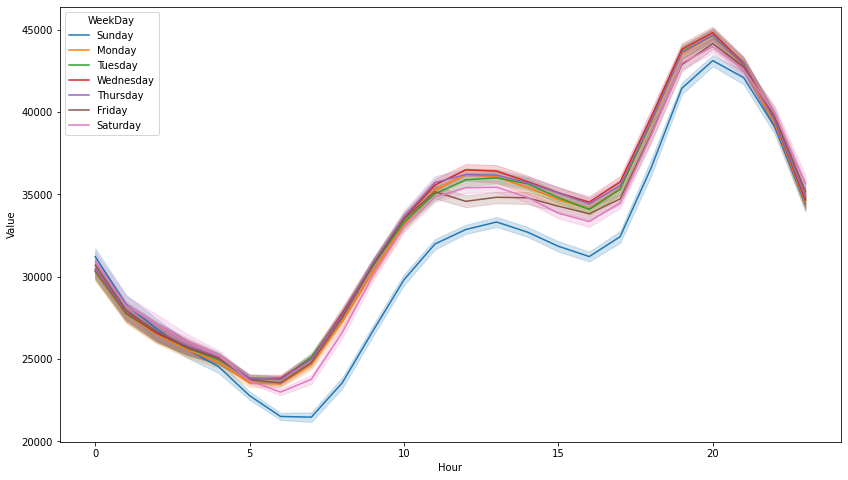

In [28]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['Hour'], data['Value'], hue = data['WeekDay'])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


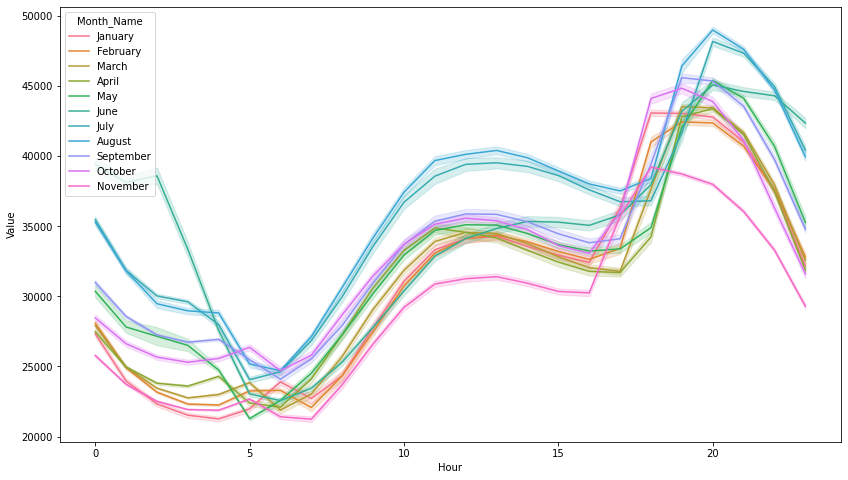

In [29]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['Hour'], data['Value'], hue = data['Month_Name'])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


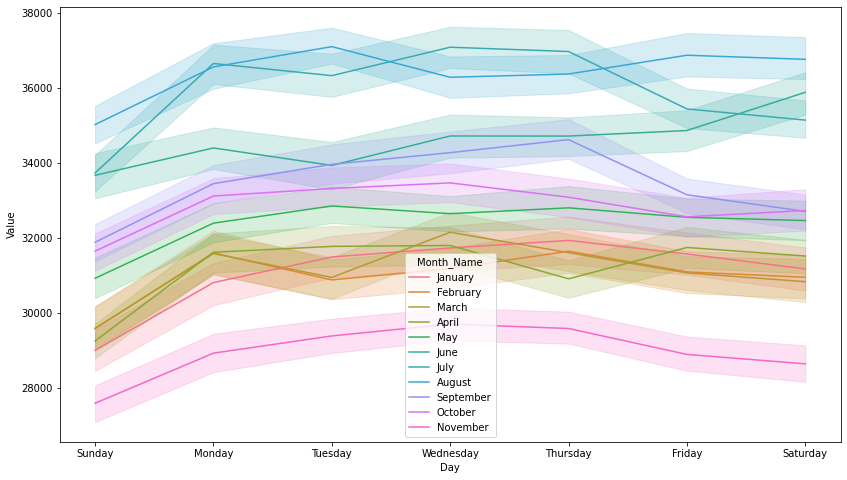

In [30]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['WeekDay'], data['Value'], hue = data['Month_Name'])
plt.xlabel('Day')
plt.ylabel('Value')
plt.show()

### Boxplot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

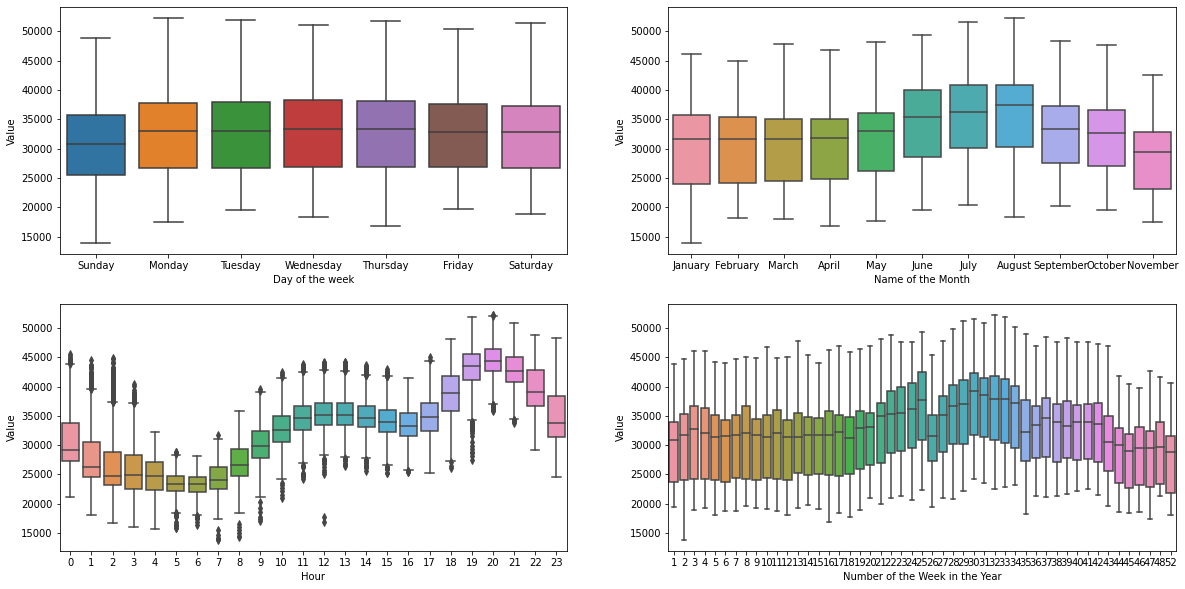

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.boxplot(data['WeekDay'], data['Value'], ax=ax[0][0]) #giorno della settimana
ax[0][0].set_xlabel('Day of the week')
ax[0][0].set_ylabel('Value')

sns.boxplot(data['Hour'], data['Value'], ax=ax[1][0]) #ora
ax[1][0].set_xlabel('Hour')
ax[1][0].set_ylabel('Value')

sns.boxplot(data['Month_Name'], data['Value'], ax=ax[0][1]) #mese
ax[0][1].set_xlabel('Name of the Month')
ax[0][1].set_ylabel('Value') 

sns.boxplot(data['Num_WeekofYear'], data['Value'], ax=ax[1][1]) #numero della settimana
ax[1][1].set_xlabel('Number of the Week in the Year')
ax[1][1].set_ylabel('Value')

plt.show()

Andamento all'interno della settimana abbastanza simile (si abbassa la domenica).
Giugno luglio e agosto in crescita, poi scende di nuovo a settembre, novembre valori più bassi. 
Durante il giorno le ore con consumi più bassi sono le 5,6,7, mentre quelle con consumi maggiori sono le 19 e le 20.
Settimana 26 segna discesa significativa, poi risale e torna a scendere alla 42 (con 44 picco negativo).

# Analisi Serie Storica

## Divisione train validation

Divido in train set e validation set.

In [32]:
train_set = data.loc[ : "2017-10-31 23:50:00"]
validation_set = data.loc["2017-11-01 00:00:00" : ]

In [33]:
validation_set

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30


## Definizione funzioni per calcolo ADF e KPSS

In [34]:
# ADF Test
def run_adf_test(x):
    result_ADF = adfuller(x.values, autolag='AIC')
    print(f'ADF Statistic: {result_ADF[0]}')
    print(f'p-value: {result_ADF[1]}')
    for key, value in result_ADF[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_ADF[1] < 0.05:
        print("The time series is stationary in mean.")
    else:
        print("The time series is not stationary in mean.")

In [35]:
# KPSS Test
def run_kpss_test(x):
    result_KPSS = kpss(x.values, regression='c')
    print('\nKPSS Statistic: %f' % result_KPSS[0])
    print('p-value: %f' % result_KPSS[1])
    for key, value in result_KPSS[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_KPSS[1] < 0.05:
        print("The time series is not stationary in variance.")
    else:
        print("The time series is stationary in variance.")

### Calcolo valori dei test sulla serie storica

#### ADF

Controllo stazionarietà in media con ADF.

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
https://www.machinelearningplus.com/time-series/time-series-analysis-python/ punto 10

In [36]:
resultADF = run_adf_test(data['Value'])

ADF Statistic: -33.537036738955436
p-value: 0.0
Critical Values:
   1%, -3.4304861235884645
Critical Values:
   5%, -2.8616001637764574
Critical Values:
   10%, -2.56680202319782
The time series is stationary in mean.


AD dice che la serie storica è stazionaria in media, rigetto l'ipotesi nulla di non stazionarietà (p-value inferiore a 0.05). Stazionaria in media.

Plot della media della serie storica.

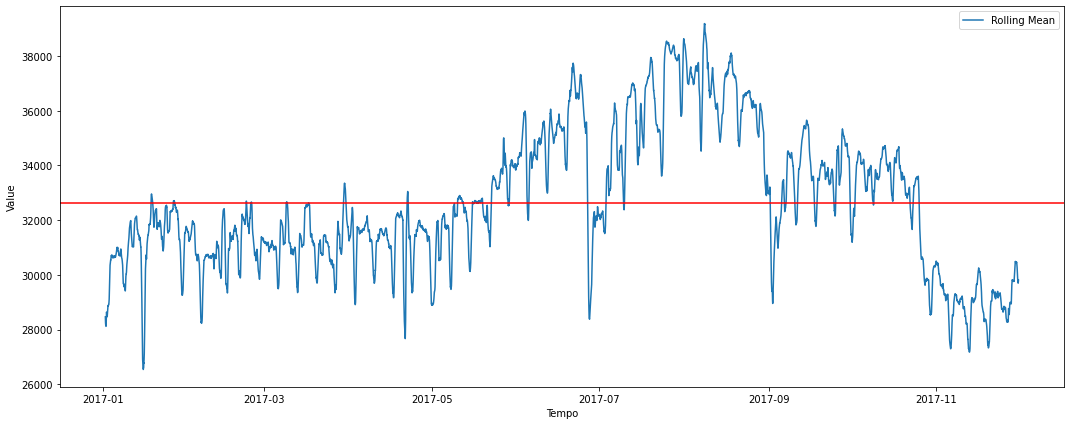

In [37]:
# Calcolo la media rolling giornaliera della serie storica
rolling_mean = data['Value'].rolling(window=144).mean() #144 è 24*6 quindi un giorno 
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_mean, label="Rolling Mean")
plt.axhline(data['Value'].mean(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

#### KPSS

Controllo stazionarietà in varianza con KPSS.

In [38]:
resultKPSS = run_kpss_test(data['Value'])


KPSS Statistic: 4.157840
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Rigetto l'ipotesi nulla di stazionarietà in varianza, KPSS mi dice che la serie storica non è stazionaria in varianza.
La serie storica non è stazionaria in varianza.

Plot della varianza della serie storica.

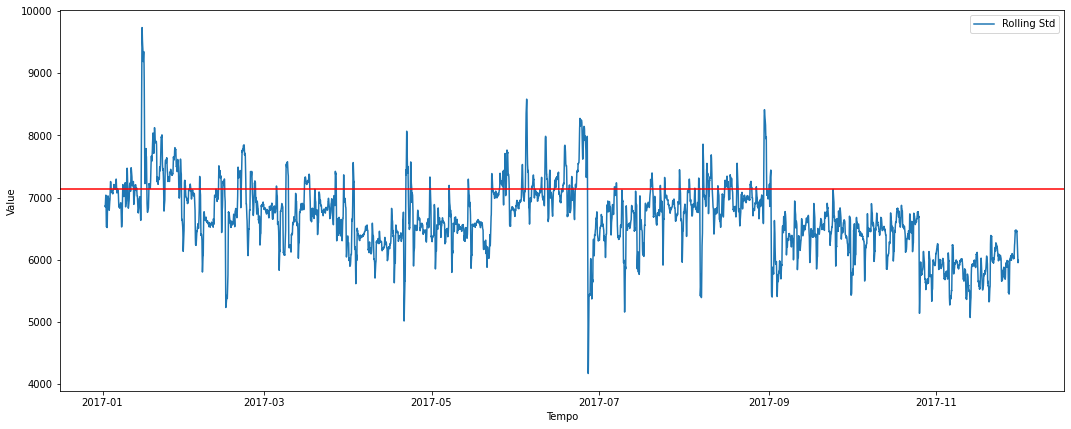

In [39]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value'].rolling(window=144).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std")
plt.axhline(data['Value'].std(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

"Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting."

In [40]:
# Philips Perron test (PP Test)

In [41]:
#Breusch Godfrey Test
# from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# test_result = acorr_breusch_godfrey(ts, model_fit)
# p_value = test_result[3]

# Trasformazioni

## Box-Cox

In [42]:
# Cerco il lambda ottimale
lambda_opt = boxcox_normmax(data['Value'])
print(lambda_opt)

# Applico Box-Cox con il lambda ottimale trovato
data['Value_BoxCox'] = boxcox(data['Value'], lmbda=lambda_opt)
print(data['Value_BoxCox'])

0.46800714402204047
Date
2017-01-01 00:00:00    280.250284
2017-01-01 00:10:00    263.209447
2017-01-01 00:20:00    260.331974
2017-01-01 00:30:00    256.508111
2017-01-01 00:40:00    252.645384
                          ...    
2017-11-30 23:10:00    269.509614
2017-11-30 23:20:00    266.470467
2017-11-30 23:30:00    263.519745
2017-11-30 23:40:00    260.842230
2017-11-30 23:50:00    258.028534
Name: Value_BoxCox, Length: 48096, dtype: float64


Testo ADF e KPSS

In [43]:
run_adf_test(data['Value_BoxCox'])

ADF Statistic: -33.370400406153365
p-value: 0.0
Critical Values:
   1%, -3.4304861264221036
Critical Values:
   5%, -2.8616001650288383
Critical Values:
   10%, -2.566802023864426
The time series is stationary in mean.


In [44]:
run_kpss_test(data['Value_BoxCox'])


KPSS Statistic: 4.171477
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Non cambia praticamente nulla, provo a procedere con una trasformazione logaritmica.

## Log

In [45]:
data['Value_Log'] = np.log(data['Value'])
print(data['Value_Log'])

Date
2017-01-01 00:00:00    10.435753
2017-01-01 00:10:00    10.302756
2017-01-01 00:20:00    10.279459
2017-01-01 00:30:00    10.248100
2017-01-01 00:40:00    10.215949
                         ...    
2017-11-30 23:10:00    10.352896
2017-11-30 23:20:00    10.328856
2017-11-30 23:30:00    10.305254
2017-11-30 23:40:00    10.283609
2017-11-30 23:50:00    10.260624
Name: Value_Log, Length: 48096, dtype: float64


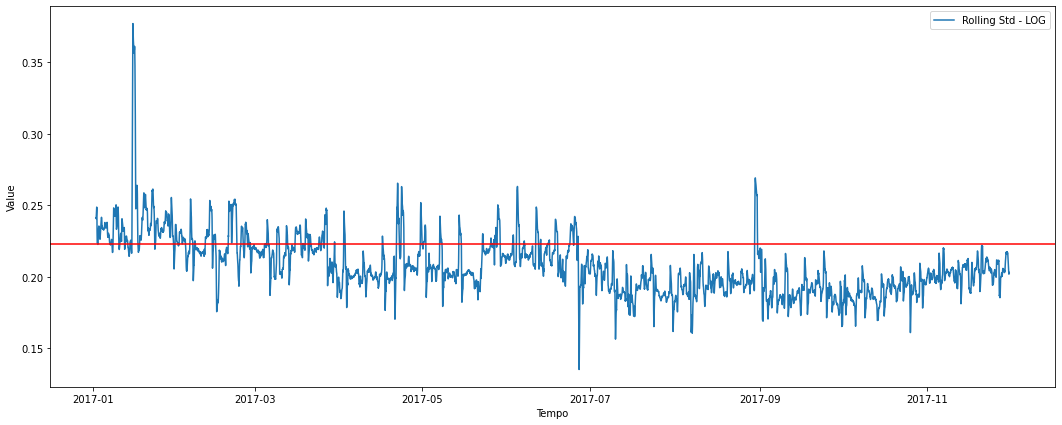

In [46]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value_Log'].rolling(window=144).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std - LOG")
plt.axhline(data['Value_Log'].std(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

Riduce la varianza della serie storica.

Testo ADF e KPSS

In [47]:
run_adf_test(data['Value_Log'])

ADF Statistic: -33.28763630998326
p-value: 0.0
Critical Values:
   1%, -3.4304861264221036
Critical Values:
   5%, -2.8616001650288383
Critical Values:
   10%, -2.566802023864426
The time series is stationary in mean.


In [48]:
run_kpss_test(data['Value_Log'])


KPSS Statistic: 4.191695
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Anche in questo caso non cambia praticamente nulla, dobbiamo procedere con una differenziazione (come suggerito anche dalla documentazione di statsmodels).

## Differenziazione

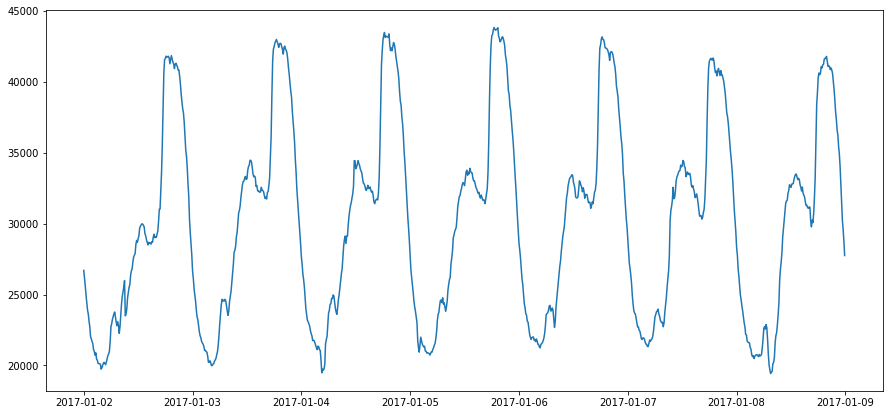

In [49]:
fig, ax = plt.subplots(1, 1, figsize =(15,7))
plt.plot(data[data['Num_WeekofYear'] == 1]['Value']) #plot della prima settimana di dati

Vedendo la prima settimana di dati si può vedere la presenza di una stagionalità giornaliera.

In [50]:
for i in range(1, data['Num_WeekofYear'].nunique()):
    fig, ax = plt.subplots(1, 1, figsize =(15,7))
    plt.plot(data[data['Num_WeekofYear'] == i]['Value'])

Output hidden; open in https://colab.research.google.com to view.

Procedo con la differenziazione giornaliera.

In [51]:
data_diff = data.copy()

In [52]:
data_diff['Value'] = data_diff['Value'].diff(144)
print(data_diff['Value']) #ci sono valori NA, quindi li devo droppare

Date
2017-01-01 00:00:00           NaN
2017-01-01 00:10:00           NaN
2017-01-01 00:20:00           NaN
2017-01-01 00:30:00           NaN
2017-01-01 00:40:00           NaN
                          ...    
2017-11-30 23:10:00    1347.69231
2017-11-30 23:20:00    1212.30769
2017-11-30 23:30:00    1286.15385
2017-11-30 23:40:00    1575.38462
2017-11-30 23:50:00    1600.00000
Name: Value, Length: 48096, dtype: float64


In [53]:
data_diff = data_diff.dropna()
print(data_diff['Value'])

Date
2017-01-02 00:00:00   -7351.89873
2017-01-02 00:10:00   -3645.56962
2017-01-02 00:20:00   -3505.82279
2017-01-02 00:30:00   -3256.70886
2017-01-02 00:40:00   -2898.22785
                          ...    
2017-11-30 23:10:00    1347.69231
2017-11-30 23:20:00    1212.30769
2017-11-30 23:30:00    1286.15385
2017-11-30 23:40:00    1575.38462
2017-11-30 23:50:00    1600.00000
Name: Value, Length: 47952, dtype: float64


Testo ADF e KPSS

In [54]:
run_adf_test(data_diff['Value'])

ADF Statistic: -19.459394832178386
p-value: 0.0
Critical Values:
   1%, -3.43048654140327
Critical Values:
   5%, -2.861600348437607
Critical Values:
   10%, -2.566802121487611
The time series is stationary in mean.


In [55]:
run_kpss_test(data_diff['Value'])


KPSS Statistic: 0.052548
p-value: 0.100000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Tramite la differenziazione giornaliera si riesce a rendere la serie storica stazionaria anche in varianza.

### ACF e PACF

ACF e PACF 

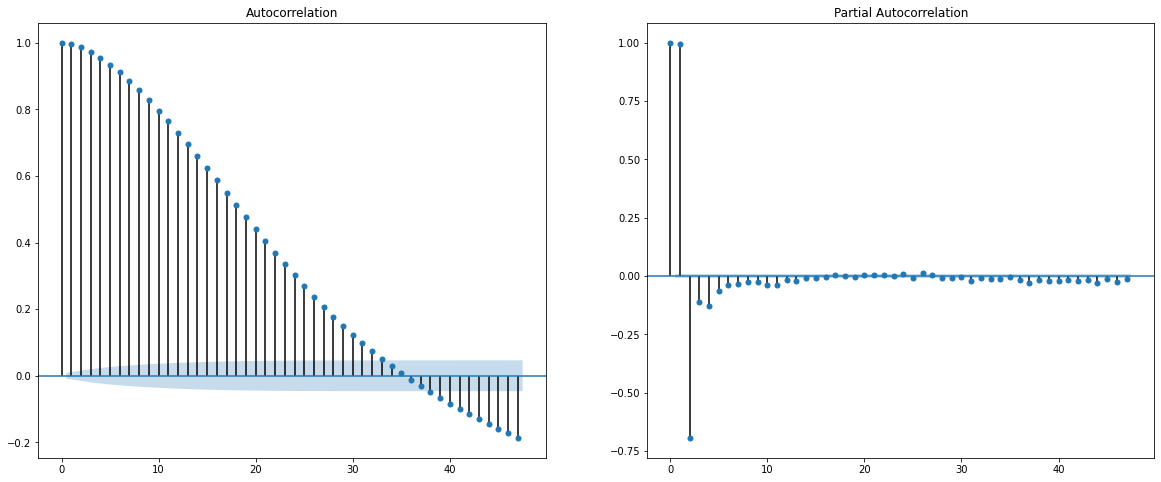

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data['Value'], ax = ax[0])
plot_pacf(data['Value'], ax = ax[1])

plt.show()

ACF rientra gradualmente verso 0, poi scende sotto lo 0: sembra oscillare. PACF esce fino al 15° ritardi circa.

ACF e PACF della serie storica differenziata.

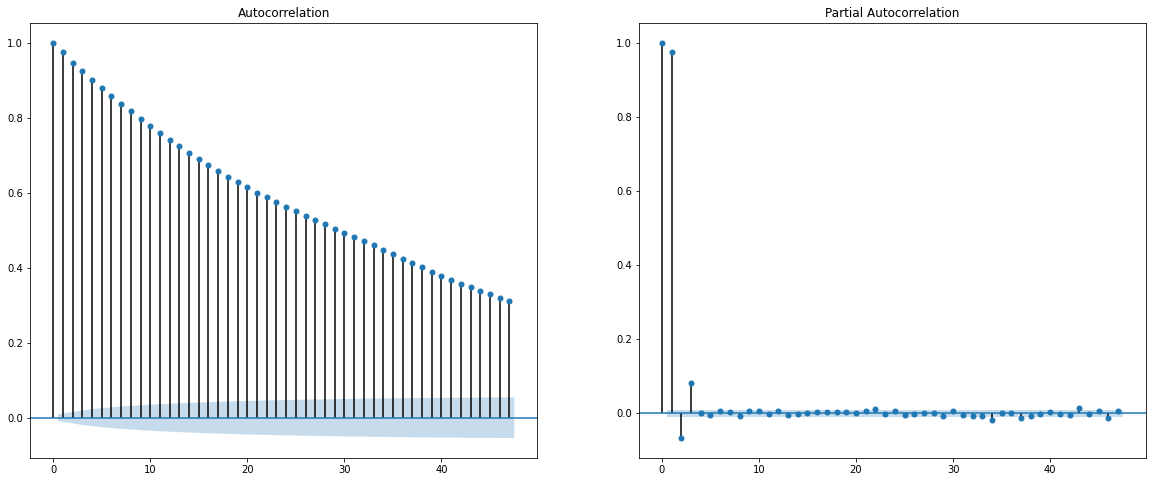

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data_diff['Value'], ax = ax[0])
plot_pacf(data_diff['Value'], ax = ax[1])

plt.show()

ACF sta rientando gradualmente verso 0. PACF ha i primi 3 ritardi che escono. 

## Divisione train-validation serie

In [58]:
# train_set_diff = data_diff.loc[ "2017-09-01 00:00:00": "2017-10-31 23:50:00"]
# validation_set_diff = data_diff.loc["2017-11-01 00:00:00" : ]

In [59]:
train = data.loc[ "2017-09-01 00:00:00": "2017-10-31 23:50:00"]
validation = data.loc["2017-11-01 00:00:00" : ] 

#### Salvataggio

In [ ]:
validation.to_csv('validation.csv', index=False)
from google.colab import files
files.download('validation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train.to_csv('train.csv', index=False)
from google.colab import files
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# UCM

## Novembre
Train fino ad ottobre, validation su novembre

### Import dati raggruppati

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
df_train_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/train_tot.csv')
df_validation_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/validation_tot.csv')

In [62]:
df_train_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,0,1,2017-01-01,280.250284,10.435753
1,2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,0,1,2017-01-01,263.209447,10.302756
2,2017-01-01 00:20:00,29128.10127,2017,1,1,0,20,0,Sunday,January,1,6,0,1,2017-01-01,260.331974,10.279459
3,2017-01-01 00:30:00,28228.86076,2017,1,1,0,30,0,Sunday,January,1,6,0,1,2017-01-01,256.508111,10.248100
4,2017-01-01 00:40:00,27335.69620,2017,1,1,0,40,0,Sunday,January,1,6,0,1,2017-01-01,252.645384,10.215949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43771,2017-10-31 23:10:00,31024.59519,2017,10,31,23,10,0,Tuesday,October,304,1,44,4,2017-10-31,268.195663,10.342536
43772,2017-10-31 23:20:00,30362.88840,2017,10,31,23,20,0,Tuesday,October,304,1,44,4,2017-10-31,265.481762,10.320976
43773,2017-10-31 23:30:00,29625.55799,2017,10,31,23,30,0,Tuesday,October,304,1,44,4,2017-10-31,262.420370,10.296393
43774,2017-10-31 23:40:00,29033.17287,2017,10,31,23,40,0,Tuesday,October,304,1,44,4,2017-10-31,259.931300,10.276194


In [63]:
df_validation_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
1,2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2,2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
3,2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
4,2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
4316,2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
4317,2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254
4318,2017-11-30 23:40:00,29249.23077,2017,11,30,23,40,0,Thursday,November,334,3,48,4,2017-11-30,260.842230,10.283609


### Set index dati raggruppati

#### Train

In [64]:
df_train_tot["Num_WeekofYear"] = df_train_tot["Num_WeekofYear"].replace(52, 0)
df_train_tot[["Num_WeekofYear","Value"]]

,Num_WeekofYear,Value
0,0,34055.69620
1,0,29814.68354
2,0,29128.10127
3,0,28228.86076
4,0,27335.69620
...,...,...
43771,44,31024.59519
43772,44,30362.88840
43773,44,29625.55799
43774,44,29033.17287


In [65]:
df_train_tot0_10 = df_train_tot[df_train_tot['Minute'].isin([0, 10])]
df_train_tot20_30 = df_train_tot[df_train_tot['Minute'].isin([20, 30])]
df_train_tot40_50 = df_train_tot[df_train_tot['Minute'].isin([40, 50])]

In [66]:
df_train_tot0_10

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,0,1,2017-01-01,280.250284,10.435753
1,2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,0,1,2017-01-01,263.209447,10.302756
6,2017-01-01 01:00:00,25998.98734,2017,1,1,1,0,0,Sunday,January,1,6,0,1,2017-01-01,246.736788,10.165813
7,2017-01-01 01:10:00,25446.07595,2017,1,1,1,10,0,Sunday,January,1,6,0,1,2017-01-01,244.245597,10.144317
12,2017-01-01 02:00:00,23003.54430,2017,1,1,2,0,0,Sunday,January,1,6,0,1,2017-01-01,232.879926,10.043404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43759,2017-10-31 21:10:00,38744.50766,2017,10,31,21,10,0,Tuesday,October,304,1,44,4,2017-10-31,297.822797,10.564744
43764,2017-10-31 22:00:00,35662.84464,2017,10,31,22,0,0,Tuesday,October,304,1,44,4,2017-10-31,286.410649,10.481865
43765,2017-10-31 22:10:00,35246.91466,2017,10,31,22,10,0,Tuesday,October,304,1,44,4,2017-10-31,284.830758,10.470133
43770,2017-10-31 23:00:00,32051.81619,2017,10,31,23,0,0,Tuesday,October,304,1,44,4,2017-10-31,272.348362,10.375109


In [67]:
grouped_df_train_tot0_10 = df_train_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_train_tot20_30 = df_train_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_train_tot40_50 = df_train_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})

In [68]:
grouped_df_train_tot0_10

Value                 Date
Hour Num_DayofYear                                   
0    1              31935.189870  2017-01-01 00:00:00
     2              26436.455695  2017-01-02 00:00:00
     3              26406.075950  2017-01-03 00:00:00
     4              27405.569620  2017-01-04 00:00:00
     5              27189.873420  2017-01-05 00:00:00
...                          ...                  ...
23   300            29909.146605  2017-10-27 23:00:00
     301            29738.993435  2017-10-28 23:00:00
     302            30312.472645  2017-10-29 23:00:00
     303            30646.477025  2017-10-30 23:00:00
     304            31538.205690  2017-10-31 23:00:00

[7296 rows x 2 columns]

In [69]:
grouped_df_train_tot0_10['third_hour'] = 1
grouped_df_train_tot20_30['third_hour'] = 2
grouped_df_train_tot40_50['third_hour'] = 3

In [70]:
grouped_df_train_tot0_10 = grouped_df_train_tot0_10.reset_index()
grouped_df_train_tot20_30 = grouped_df_train_tot20_30.reset_index()
grouped_df_train_tot40_50 = grouped_df_train_tot40_50.reset_index()

In [71]:
grouped_df_train_tot0_10

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,1,31935.189870,2017-01-01 00:00:00,1
1,0,2,26436.455695,2017-01-02 00:00:00,1
2,0,3,26406.075950,2017-01-03 00:00:00,1
3,0,4,27405.569620,2017-01-04 00:00:00,1
4,0,5,27189.873420,2017-01-05 00:00:00,1
...,...,...,...,...,...
7291,23,300,29909.146605,2017-10-27 23:00:00,1
7292,23,301,29738.993435,2017-10-28 23:00:00,1
7293,23,302,30312.472645,2017-10-29 23:00:00,1
7294,23,303,30646.477025,2017-10-30 23:00:00,1


In [72]:
grouped_train_tot = pd.concat([grouped_df_train_tot0_10,
                           grouped_df_train_tot20_30,
                           grouped_df_train_tot40_50], ignore_index=True)

In [73]:
# grouped_train_tot = grouped_train_tot.drop(columns = 'index')

In [74]:
grouped_train_tot

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,1,31935.189870,2017-01-01 00:00:00,1
1,0,2,26436.455695,2017-01-02 00:00:00,1
2,0,3,26406.075950,2017-01-03 00:00:00,1
3,0,4,27405.569620,2017-01-04 00:00:00,1
4,0,5,27189.873420,2017-01-05 00:00:00,1
...,...,...,...,...,...
21883,23,300,27668.796500,2017-10-27 23:40:00,3
21884,23,301,27435.623635,2017-10-28 23:40:00,3
21885,23,302,27716.061270,2017-10-29 23:40:00,3
21886,23,303,28327.352300,2017-10-30 23:40:00,3


#### Validation

In [75]:
df_validation_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
1,2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2,2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
3,2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
4,2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
4316,2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
4317,2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254
4318,2017-11-30 23:40:00,29249.23077,2017,11,30,23,40,0,Thursday,November,334,3,48,4,2017-11-30,260.842230,10.283609


In [76]:
df_validation_tot["Num_WeekofYear"] = df_validation_tot["Num_WeekofYear"].replace(52, 0)
df_validation_tot[["Num_WeekofYear","Value"]]

,Num_WeekofYear,Value
0,44,27089.23077
1,44,26701.53846
2,44,26375.38462
3,44,25963.07692
4,44,25593.84615
...,...,...
4315,48,31347.69231
4316,48,30603.07692
4317,48,29889.23077
4318,48,29249.23077


In [77]:
df_validation_tot0_10 = df_validation_tot[df_validation_tot['Minute'].isin([0, 10])]
df_validation_tot20_30 = df_validation_tot[df_validation_tot['Minute'].isin([20, 30])]
df_validation_tot40_50 = df_validation_tot[df_validation_tot['Minute'].isin([40, 50])]

In [78]:
df_validation_tot0_10

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
1,2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
6,2017-11-01 01:00:00,24849.23077,2017,11,1,1,0,0,Wednesday,November,305,2,44,4,2017-11-01,241.523919,10.120582
7,2017-11-01 01:10:00,24572.30769,2017,11,1,1,10,0,Wednesday,November,305,2,44,4,2017-11-01,240.249310,10.109375
12,2017-11-01 02:00:00,23624.61538,2017,11,1,2,0,0,Wednesday,November,305,2,44,4,2017-11-01,235.828487,10.070044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,2017-11-30 21:10:00,37267.69231,2017,11,30,21,10,0,Thursday,November,334,3,48,4,2017-11-30,292.416508,10.525882
4308,2017-11-30 22:00:00,35150.76923,2017,11,30,22,0,0,Thursday,November,334,3,48,4,2017-11-30,284.464145,10.467402
4309,2017-11-30 22:10:00,34941.53846,2017,11,30,22,10,0,Thursday,November,334,3,48,4,2017-11-30,283.664477,10.461432
4314,2017-11-30 23:00:00,32067.69231,2017,11,30,23,0,0,Thursday,November,334,3,48,4,2017-11-30,272.411983,10.375604


In [79]:
grouped_df_validation_tot0_10 = df_validation_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_validation_tot20_30 = df_validation_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_validation_tot40_50 = df_validation_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})

In [80]:
grouped_df_validation_tot0_10

Value                 Date
Hour Num_DayofYear                                   
0    305            26895.384615  2017-11-01 00:00:00
     306            27018.461540  2017-11-02 00:00:00
     307            26723.076925  2017-11-03 00:00:00
     308            26747.692305  2017-11-04 00:00:00
     309            27630.769230  2017-11-05 00:00:00
...                          ...                  ...
23   330            30732.307695  2017-11-26 23:00:00
     331            30744.615385  2017-11-27 23:00:00
     332            30621.538465  2017-11-28 23:00:00
     333            30344.615385  2017-11-29 23:00:00
     334            31707.692310  2017-11-30 23:00:00

[720 rows x 2 columns]

In [81]:
grouped_df_validation_tot0_10['third_hour'] = 1
grouped_df_validation_tot20_30['third_hour'] = 2
grouped_df_validation_tot40_50['third_hour'] = 3

In [82]:
grouped_df_validation_tot0_10 = grouped_df_validation_tot0_10.reset_index()
grouped_df_validation_tot20_30 = grouped_df_validation_tot20_30.reset_index()
grouped_df_validation_tot40_50 = grouped_df_validation_tot40_50.reset_index()

In [83]:
grouped_df_validation_tot0_10

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,305,26895.384615,2017-11-01 00:00:00,1
1,0,306,27018.461540,2017-11-02 00:00:00,1
2,0,307,26723.076925,2017-11-03 00:00:00,1
3,0,308,26747.692305,2017-11-04 00:00:00,1
4,0,309,27630.769230,2017-11-05 00:00:00,1
...,...,...,...,...,...
715,23,330,30732.307695,2017-11-26 23:00:00,1
716,23,331,30744.615385,2017-11-27 23:00:00,1
717,23,332,30621.538465,2017-11-28 23:00:00,1
718,23,333,30344.615385,2017-11-29 23:00:00,1


In [84]:
grouped_validation_tot = pd.concat([grouped_df_validation_tot0_10,
                           grouped_df_validation_tot20_30,
                           grouped_df_validation_tot40_50], ignore_index=True)

In [85]:
# grouped_validation_tot = grouped_validation_tot.drop(columns = 'index')

In [86]:
grouped_validation_tot

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,305,26895.384615,2017-11-01 00:00:00,1
1,0,306,27018.461540,2017-11-02 00:00:00,1
2,0,307,26723.076925,2017-11-03 00:00:00,1
3,0,308,26747.692305,2017-11-04 00:00:00,1
4,0,309,27630.769230,2017-11-05 00:00:00,1
...,...,...,...,...,...
2155,23,330,27735.384615,2017-11-26 23:40:00,3
2156,23,331,28184.615385,2017-11-27 23:40:00,3
2157,23,332,28153.846155,2017-11-28 23:40:00,3
2158,23,333,27329.230765,2017-11-29 23:40:00,3


### Grid Search per modelli

In [87]:
grouped_train_tot = grouped_train_tot.set_index("Date")
grouped_validation_tot = grouped_validation_tot.set_index("Date")

In [88]:
grouped_train_tot

,Hour,Num_DayofYear,Value,third_hour
Date,,,,
2017-01-01 00:00:00,0,1,31935.189870,1
2017-01-02 00:00:00,0,2,26436.455695,1
2017-01-03 00:00:00,0,3,26406.075950,1
2017-01-04 00:00:00,0,4,27405.569620,1
2017-01-05 00:00:00,0,5,27189.873420,1
...,...,...,...,...
2017-10-27 23:40:00,23,300,27668.796500,3
2017-10-28 23:40:00,23,301,27435.623635,3
2017-10-29 23:40:00,23,302,27716.061270,3


In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

levels = ['ntrend',  # No trend
          'dconstant',  # Deterministic constant
          'llevel',  # Local level
          'rwalk',  # Random walk
          'dtrend',  # Deterministic trend
          'lldtrend',  #Local linear deterministic trend
          'rwdrift',  # Random walk with drift
          'lltrend',  # Local linear trend
          'strend',  # Smooth trend
          'rtrend',  # Random trend
          ]

harmonics_weekly = [1,2,3,4,5,6,7,8,9,10]

predictions_df = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'third_hour', 'Value', 'predicted'])
inds = pd.date_range(start='2017-01-01', end='2017-10-31', freq='D')


for l in levels:
  for i in harmonics_weekly:
    for j in range(24):
      for k in range(1,4):
        df_ucm = grouped_train_tot[(grouped_train_tot['Hour'] == j) & (grouped_train_tot['third_hour'] == k)]
        train = pd.Series(df_ucm['Value'].values, index=inds)

        mod = UnobservedComponents(train,
                                  seasonal = 7,
                                  level = l,     
                                  freq_seasonal = [{'period': 7, 'harmonics': i}],
                                  random_state = 123
                                  )
        mod = mod.fit()
        pred = mod.get_prediction(start=grouped_validation_tot.index[0], end=grouped_validation_tot.index[-1]).predicted_mean
        pred = pred.drop(pred.index[-1])

        pred_df = pd.DataFrame({'Num_DayofYear':  grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['Num_DayofYear'], 
                                'Hour': grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['Hour'], 
                                'third_hour': grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['third_hour'], 
                                'Value': grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['Value'].values, 
                                'predicted': pred.values,
                                })
        predictions_df = predictions_df.append(pred_df, ignore_index=True)
        
        
    predictions_df.sort_values(by=['Num_DayofYear', 'Hour', 'third_hour'])
    mae_err = metrics.mean_absolute_error(predictions_df['Value'], predictions_df['predicted'])
    #print(predictions_df)
    predictions_df = pd.DataFrame(columns=['Value', 'predicted'])
    print([l, i, mod.aic, mae_err]);
    del mod

['ntrend', 1, 7125.918698199002, 33772.0818113344]
['ntrend', 2, 7380.821978075458, 32790.38584348108]
['ntrend', 3, 7542.57692011504, 31674.868389609772]
['ntrend', 4, 7525.201080913136, 31593.702666261404]
['ntrend', 5, 7491.294861289529, 31756.1704689303]
['ntrend', 6, 7400.4832054576555, 32076.537666833297]
['ntrend', 7, 5153.636496890973, 2381.920579926947]
['ntrend', 8, 5122.12728916173, 2446.4259485601756]
['ntrend', 9, 5106.536001308622, 2578.9021309337363]
['ntrend', 10, 5089.945816638241, 2681.0824432372833]
['dconstant', 1, 6564.658133947276, 3627.2422954347066]
['dconstant', 2, 6492.396931369362, 3617.099655535054]
['dconstant', 3, 6411.815353046794, 3613.468328068407]
['dconstant', 4, 6347.636146705263, 3605.7497504052258]
['dconstant', 5, 6284.961807017936, 3596.6003043735927]
['dconstant', 6, 6223.836245971674, 3588.966023103031]
['dconstant', 7, 5129.209690258158, 2497.8866484364994]
['dconstant', 8, 5104.634607000226, 2560.8882958606046]
['dconstant', 9, 5087.892566545

### REVERT NOVEMBRE
train fino ad ottobre, validation da 1 a 30 novembre

In [89]:
grouped_var_df_train_tot0_10 = df_train_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_df_train_tot20_30 = df_train_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_df_train_tot40_50 = df_train_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})

In [90]:
grouped_var_df_train_tot0_10

Value
Hour Num_DayofYear              
0    1              8.993094e+06
     2              1.429432e+05
     3              1.302437e+05
     4              1.271612e+05
     5              4.492080e+05
...                          ...
23   300            2.490913e+05
     301            1.985741e+05
     302            1.270874e+05
     303            2.316168e+05
     304            5.275915e+05

[7296 rows x 1 columns]

In [91]:
grouped_var_df_train_tot0_10_noind = grouped_var_df_train_tot0_10.reset_index()
grouped_var_df_train_tot20_30_noind = grouped_var_df_train_tot20_30.reset_index()
grouped_var_df_train_tot40_50_noind = grouped_var_df_train_tot40_50.reset_index()

In [92]:
grouped_var_df_train_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,1,8.993094e+06
1,0,2,1.429432e+05
2,0,3,1.302437e+05
3,0,4,1.271612e+05
4,0,5,4.492080e+05
...,...,...,...
7291,23,300,2.490913e+05
7292,23,301,1.985741e+05
7293,23,302,1.270874e+05
7294,23,303,2.316168e+05


In [93]:
grouped_median_train_tot0_10 = grouped_var_df_train_tot0_10_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_tot20_30 = grouped_var_df_train_tot20_30_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_tot40_50 = grouped_var_df_train_tot40_50_noind.groupby(["Hour"]).agg({'Value':'median'})

In [94]:
grouped_median_train_tot0_10

,Value
Hour,
0,218784.316194
1,84625.012988
2,22432.501793
3,7509.642190
4,13082.943837
5,77292.295274
6,50747.904829
7,120548.550079
8,198357.186112


In [95]:
grouped_median_train_tot0_10_noind = grouped_median_train_tot0_10.reset_index()
grouped_median_train_tot20_30_noind = grouped_median_train_tot20_30.reset_index()
grouped_median_train_tot40_50_noind = grouped_median_train_tot40_50.reset_index()

In [96]:
grouped_median_train_tot0_10_noind

,Hour,Value
0,0,218784.316194
1,1,84625.012988
2,2,22432.501793
3,3,7509.642190
4,4,13082.943837
5,5,77292.295274
6,6,50747.904829
7,7,120548.550079
8,8,198357.186112
9,9,178677.055171


In [97]:
grouped_median_train_tot0_10_noind = grouped_median_train_tot0_10_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_tot20_30_noind = grouped_median_train_tot20_30_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_tot40_50_noind = grouped_median_train_tot40_50_noind.rename(columns = {'Value' : 'var'})

In [98]:
grouped_median_train_tot0_10_noind

,Hour,var
0,0,218784.316194
1,1,84625.012988
2,2,22432.501793
3,3,7509.642190
4,4,13082.943837
5,5,77292.295274
6,6,50747.904829
7,7,120548.550079
8,8,198357.186112
9,9,178677.055171


#### Previsioni per combinazione migliore

In [99]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

predictions_df = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'third_hour', 'Value', 'predicted'])
inds = pd.date_range(start='2017-01-01', end='2017-10-31', freq='D')


for j in range(24):
  for k in range(1,4):
    df_ucm = grouped_train_tot[(grouped_train_tot['Hour'] == j) & (grouped_train_tot['third_hour'] == k)]
    train = pd.Series(df_ucm['Value'].values, index=inds)

    mod = UnobservedComponents(train,
                              seasonal = 7,
                              level = 'rwalk',
                              freq_seasonal = [{'period': 7, 'harmonics': 9}],
                              random_state = 123
                              )
    mod = mod.fit()
    pred = mod.get_prediction(start=grouped_validation_tot.index[0], end=grouped_validation_tot.index[-1]).predicted_mean
    pred = pred.drop(pred.index[-1])

    pred_df = pd.DataFrame({'Num_DayofYear':  grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['Num_DayofYear'], 
                            'Hour': grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['Hour'], 
                            'third_hour': grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['third_hour'], 
                            'Value': grouped_validation_tot[(grouped_validation_tot['Hour'] == j) & (grouped_validation_tot['third_hour'] == k)]['Value'].values, 
                            'predicted': pred.values,
                            })
    predictions_df = predictions_df.append(pred_df, ignore_index=True)
    
    
predictions_df.sort_values(by=['Num_DayofYear', 'Hour', 'third_hour'])
mae_err = metrics.mean_absolute_error(predictions_df['Value'], predictions_df['predicted'])
#print(predictions_df)
#predictions_df = pd.DataFrame(columns=['Value', 'predicted'])
print(['rwalk', 9, mod.aic, mae_err]);
del mod

['rwalk', 9, 4837.426196331773, 1086.2457828085162]


In [100]:
predictions_df

,Num_DayofYear,Hour,third_hour,Value,predicted
0,305,0,1,26895.384615,27557.588996
1,306,0,1,27018.461540,27093.285374
2,307,0,1,26723.076925,27163.126271
3,308,0,1,26747.692305,27574.858786
4,309,0,1,27630.769230,27980.081277
...,...,...,...,...,...
2155,330,23,3,27735.384615,27924.949556
2156,331,23,3,28184.615385,28192.195874
2157,332,23,3,28153.846155,28771.641140
2158,333,23,3,27329.230765,27844.169700


In [101]:
import numpy as np

def generate_sequence(mean, variance, num_samples):
    return np.linspace(mean - np.sqrt(variance), mean + np.sqrt(variance), num_samples)

In [102]:
# grouped_median_train_tot0_30_noind = grouped_median_train_tot0_30_noind.drop('index', axis=1)
# grouped_median_train_tot30_60_noind = grouped_median_train_tot30_60_noind.drop('index', axis=1)

In [103]:
grouped_median_train_tot0_10_noind

,Hour,var
0,0,218784.316194
1,1,84625.012988
2,2,22432.501793
3,3,7509.642190
4,4,13082.943837
5,5,77292.295274
6,6,50747.904829
7,7,120548.550079
8,8,198357.186112
9,9,178677.055171


In [104]:
df_predictions1 = predictions_df.loc[predictions_df["third_hour"] == 1]
df_predictions2 = predictions_df.loc[predictions_df["third_hour"] == 2]
df_predictions3 = predictions_df.loc[predictions_df["third_hour"] == 3]

In [105]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted
0,305,0,1,26895.384615,27557.588996
1,306,0,1,27018.461540,27093.285374
2,307,0,1,26723.076925,27163.126271
3,308,0,1,26747.692305,27574.858786
4,309,0,1,27630.769230,27980.081277
...,...,...,...,...,...
2095,330,23,1,30732.307695,30672.714705
2096,331,23,1,30744.615385,30637.156469
2097,332,23,1,30621.538465,31538.205690
2098,333,23,1,30344.615385,30381.709127


In [106]:
df_predictions1 = df_predictions1.merge(grouped_median_train_tot0_10_noind, on = "Hour")
df_predictions2 = df_predictions2.merge(grouped_median_train_tot20_30_noind, on = "Hour")
df_predictions3 = df_predictions3.merge(grouped_median_train_tot40_50_noind, on = "Hour")

In [107]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,1,26895.384615,27557.588996,218784.316194
1,306,0,1,27018.461540,27093.285374,218784.316194
2,307,0,1,26723.076925,27163.126271,218784.316194
3,308,0,1,26747.692305,27574.858786,218784.316194
4,309,0,1,27630.769230,27980.081277,218784.316194
...,...,...,...,...,...,...
715,330,23,1,30732.307695,30672.714705,306557.055143
716,331,23,1,30744.615385,30637.156469,306557.055143
717,332,23,1,30621.538465,31538.205690,306557.055143
718,333,23,1,30344.615385,30381.709127,306557.055143


In [108]:
df_predictions1 = df_predictions1.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions2 = df_predictions2.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions3 = df_predictions3.sort_values(by=['Num_DayofYear', 'Hour'])

In [109]:
df_predictions1 = df_predictions1.reset_index(drop = True)
df_predictions2 = df_predictions2.reset_index(drop = True)
df_predictions3 = df_predictions3.reset_index(drop = True)

In [110]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,1,26895.384615,27557.588996,218784.316194
1,305,1,1,24710.769230,25231.056351,84625.012988
2,305,2,1,23455.384615,23497.653835,22432.501793
3,305,3,1,22981.538460,23003.263077,7509.642190
4,305,4,1,22707.692305,23294.916310,13082.943837
...,...,...,...,...,...,...
715,334,19,1,39729.230770,39892.165317,253787.410902
716,334,20,1,38916.923075,39372.938585,39726.008029
717,334,21,1,37535.384615,37223.638127,43762.746222
718,334,22,1,35046.153845,34859.084692,162275.782107


##### Predictions 1

In [111]:
df_predictions1_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [112]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,1,26895.384615,27557.588996,218784.316194
1,305,1,1,24710.769230,25231.056351,84625.012988
2,305,2,1,23455.384615,23497.653835,22432.501793
3,305,3,1,22981.538460,23003.263077,7509.642190
4,305,4,1,22707.692305,23294.916310,13082.943837
...,...,...,...,...,...,...
715,334,19,1,39729.230770,39892.165317,253787.410902
716,334,20,1,38916.923075,39372.938585,39726.008029
717,334,21,1,37535.384615,37223.638127,43762.746222
718,334,22,1,35046.153845,34859.084692,162275.782107


In [113]:
def decompose(row, df_predictions1_final):
  index = row.name

  Num_DayofYear = df_predictions1.loc[index]['Num_DayofYear']
  hour = df_predictions1.loc[index]['Hour']

  gens = generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions1.loc[index]['predicted'] > df_predictions1.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(0, 20, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions1_final = df_predictions1_final.append(new_row, ignore_index=True)
  return df_predictions1_final

In [114]:
df_predictions1_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions1.iterrows():
    df_predictions1_final = decompose(row, df_predictions1_final)

In [115]:
generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

array([29937.62663721, 31044.97853275])

In [116]:
df_predictions1_final['Num_DayofYear'] = df_predictions1_final['Num_DayofYear'].astype(int)
df_predictions1_final['Hour'] = df_predictions1_final['Hour'].astype(int)
df_predictions1_final['Minute'] = df_predictions1_final['Minute'].astype(int)

In [117]:
df_predictions1_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,28025.332854
1,305,0,10,27089.845139
2,305,1,0,25521.960137
3,305,1,10,24940.152565
4,305,2,0,23647.428672
...,...,...,...,...
1435,334,21,10,37014.442653
1436,334,22,0,35261.919376
1437,334,22,10,34456.250009
1438,334,23,0,29937.626637


##### Predictions 2

In [118]:
df_predictions2

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,2,26169.230770,26438.680526,186202.723693
1,305,1,2,24129.230770,24520.938981,63407.133201
2,305,2,2,23230.769230,23426.298158,19507.494932
3,305,3,2,22778.461535,22938.400443,11692.317487
4,305,4,2,22969.230770,23525.568544,23622.357674
...,...,...,...,...,...,...
715,334,19,2,39369.230770,39977.976966,66856.765095
716,334,20,2,38904.615385,38941.059099,14894.212234
717,334,21,2,36596.923080,36370.220491,95636.640546
718,334,22,2,34156.923075,33226.258852,290053.093126


In [119]:
df_predictions2_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [120]:
def decompose(row, df_predictions2_final):
  index = row.name

  Num_DayofYear = df_predictions2.loc[index]['Num_DayofYear']
  hour = df_predictions2.loc[index]['Hour']

  gens = generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions2.loc[index]['predicted'] > df_predictions2.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(20, 40, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions2_final = df_predictions2_final.append(new_row, ignore_index=True)
  return df_predictions2_final

In [121]:
df_predictions2_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions2.iterrows():
    df_predictions2_final = decompose(row, df_predictions2_final)

In [122]:
generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

array([28802.8146205 , 29983.89870159])

In [123]:
df_predictions2_final['Num_DayofYear'] = df_predictions2_final['Num_DayofYear'].astype(int)
df_predictions2_final['Hour'] = df_predictions2_final['Hour'].astype(int)
df_predictions2_final['Minute'] = df_predictions2_final['Minute'].astype(int)

In [124]:
df_predictions2_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,20,26870.192662
1,305,0,30,26007.168390
2,305,1,20,24772.746712
3,305,1,30,24269.131250
4,305,2,20,23565.967392
...,...,...,...,...
1435,334,21,30,36060.968748
1436,334,22,20,33764.824626
1437,334,22,30,32687.693078
1438,334,23,20,28802.814621


##### Predictions 3

In [125]:
df_predictions3

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,3,25353.846150,25708.892877,136519.657401
1,305,1,3,23655.384615,24107.275872,42117.798879
2,305,2,3,23135.384615,23299.719202,12478.000550
3,305,3,3,22735.384615,23048.060847,12478.000550
4,305,4,3,23206.153850,23454.726661,66800.324339
...,...,...,...,...,...,...
715,334,19,3,38953.846155,39523.396084,28025.210296
716,334,20,3,38313.846150,38319.575481,27147.300862
717,334,21,3,35861.538460,35854.019789,103985.978166
718,334,22,3,33243.076920,31622.573755,330447.143706


In [126]:
df_predictions3_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [127]:
def decompose(row, df_predictions3_final):
  index = row.name

  Num_DayofYear = df_predictions3.loc[index]['Num_DayofYear']
  hour = df_predictions3.loc[index]['Hour']

  gens = generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions3.loc[index]['predicted'] > df_predictions3.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(40, 60, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions3_final = df_predictions3_final.append(new_row, ignore_index=True)
  return df_predictions3_final

In [128]:
df_predictions3_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions3.iterrows():
    df_predictions3_final = decompose(row, df_predictions3_final)

In [129]:
generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

array([27598.12582173, 28667.02123198])

In [130]:
df_predictions3_final['Num_DayofYear'] = df_predictions3_final['Num_DayofYear'].astype(int)
df_predictions3_final['Hour'] = df_predictions3_final['Hour'].astype(int)
df_predictions3_final['Minute'] = df_predictions3_final['Minute'].astype(int)

In [131]:
df_predictions3_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,40,26078.378543
1,305,0,50,25339.407211
2,305,1,40,24312.502086
3,305,1,50,23902.049658
4,305,2,40,23411.424173
...,...,...,...,...
1435,334,21,50,35531.551220
1436,334,22,40,32197.419077
1437,334,22,50,31047.728434
1438,334,23,40,27598.125822


##### Merge

In [132]:
df_predictions_final = pd.concat([df_predictions1_final, df_predictions2_final, df_predictions3_final])

In [133]:
df_predictions_final= df_predictions_final.sort_values(by="Minute", ascending=True)

In [134]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,28025.332854
1146,328,21,0,37575.918446
586,317,5,0,24183.333503
588,317,6,0,21993.582353
1144,328,20,0,38700.130314
...,...,...,...,...
293,311,2,50,23227.638574
849,322,16,50,30068.722934
851,322,17,50,38735.137501
837,322,10,50,31806.996364


In [135]:
df_predictions_final = df_predictions_final.sort_values(["Num_DayofYear", "Hour"])

In [136]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,28025.332854
1,305,0,10,27089.845139
0,305,0,20,26870.192662
1,305,0,30,26007.168390
0,305,0,40,26078.378543
...,...,...,...,...
1439,334,23,10,31044.978533
1438,334,23,20,28802.814621
1439,334,23,30,29983.898702
1438,334,23,40,27598.125822


In [137]:
df_predictions_final = df_predictions_final.reset_index(drop=True)

In [138]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,28025.332854
1,305,0,10,27089.845139
2,305,0,20,26870.192662
3,305,0,30,26007.168390
4,305,0,40,26078.378543
...,...,...,...,...
4315,334,23,10,31044.978533
4316,334,23,20,28802.814621
4317,334,23,30,29983.898702
4318,334,23,40,27598.125822


In [139]:
df_validation_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
1,2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2,2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
3,2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
4,2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
4316,2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
4317,2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254
4318,2017-11-30 23:40:00,29249.23077,2017,11,30,23,40,0,Thursday,November,334,3,48,4,2017-11-30,260.842230,10.283609


##### Valutazione

In [140]:
df_validation_tot["Value"]

0       27089.23077
1       26701.53846
2       26375.38462
3       25963.07692
4       25593.84615
           ...     
4315    31347.69231
4316    30603.07692
4317    29889.23077
4318    29249.23077
4319    28584.61538
Name: Value, Length: 4320, dtype: float64

In [141]:
df_predictions_final["predicted"]

0       28025.332854
1       27089.845139
2       26870.192662
3       26007.168390
4       26078.378543
            ...     
4315    31044.978533
4316    28802.814621
4317    29983.898702
4318    27598.125822
4319    28667.021232
Name: predicted, Length: 4320, dtype: float64

In [142]:
from sklearn import metrics

mae_value = metrics.mean_absolute_error(df_validation_tot["Value"], df_predictions_final["predicted"])
print("MAE value is:", mae_value)

MAE value is: 1106.9245447176431


### Plot Predizioni vs Validation Set

In [143]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,28025.332854
1,305,0,10,27089.845139
2,305,0,20,26870.192662
3,305,0,30,26007.168390
4,305,0,40,26078.378543
...,...,...,...,...
4315,334,23,10,31044.978533
4316,334,23,20,28802.814621
4317,334,23,30,29983.898702
4318,334,23,40,27598.125822


In [157]:
df_validation_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
0,2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
1,2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2,2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
3,2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
4,2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
4316,2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
4317,2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254
4318,2017-11-30 23:40:00,29249.23077,2017,11,30,23,40,0,Thursday,November,334,3,48,4,2017-11-30,260.842230,10.283609


In [158]:
df_validation_tot['Date'] = pd.to_datetime(df_validation_tot.Date)

In [159]:
df_validation_tot = df_validation_tot.set_index('Date')

In [160]:
df_validation_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
Date,,,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254


In [144]:
start_date = '2017-11-01 00:00:00'
end_date = '2017-11-30 23:59:59'

date_range = pd.date_range(start=start_date, end=end_date, freq='10min')

prova = df_predictions_final.copy()
prova['date'] = date_range
prova = prova.set_index('date')

In [145]:
prova

,Num_DayofYear,Hour,Minute,predicted
date,,,,
2017-11-01 00:00:00,305,0,0,28025.332854
2017-11-01 00:10:00,305,0,10,27089.845139
2017-11-01 00:20:00,305,0,20,26870.192662
2017-11-01 00:30:00,305,0,30,26007.168390
2017-11-01 00:40:00,305,0,40,26078.378543
...,...,...,...,...
2017-11-30 23:10:00,334,23,10,31044.978533
2017-11-30 23:20:00,334,23,20,28802.814621
2017-11-30 23:30:00,334,23,30,29983.898702


In [146]:
prova = prova.drop(columns = ["Num_DayofYear", "Hour", "Minute"])

In [153]:
prova

,predicted
date,
2017-11-01 00:00:00,28025.332854
2017-11-01 00:10:00,27089.845139
2017-11-01 00:20:00,26870.192662
2017-11-01 00:30:00,26007.168390
2017-11-01 00:40:00,26078.378543
...,...
2017-11-30 23:10:00,31044.978533
2017-11-30 23:20:00,28802.814621
2017-11-30 23:30:00,29983.898702


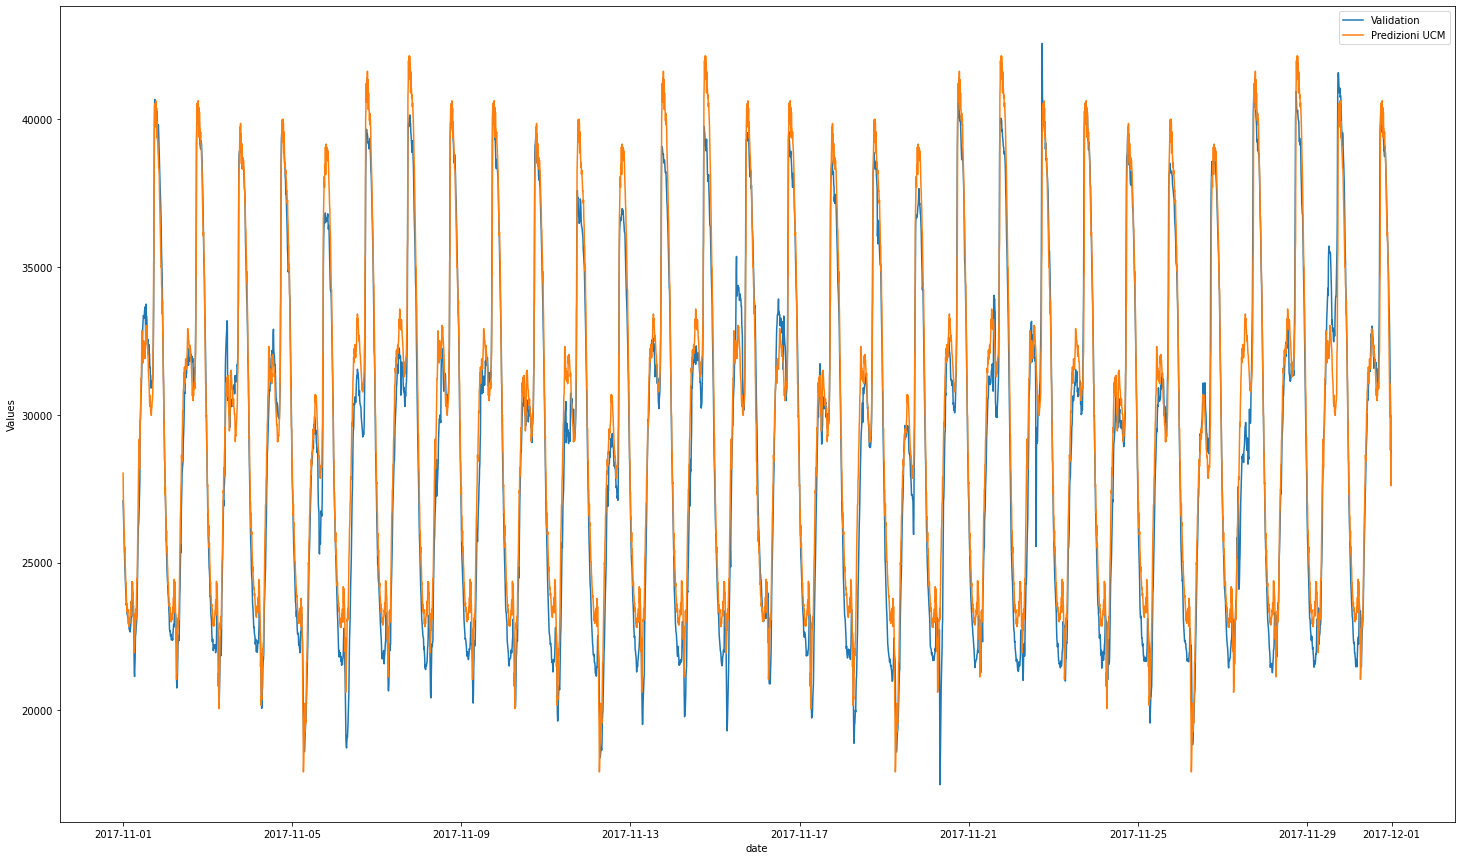

In [162]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(df_validation_tot.index, df_validation_tot.Value, label='Validation')
plt.plot(prova.index, prova.predicted, label='Predizioni UCM')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

## Dicembre

### Import dati raggruppati DICEMBRE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train_dic_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/train_dic_tot.csv')
df_validation_dic_tot = pd.read_csv('/content/drive/MyDrive/Progetto SDMTSA/validation_dic_tot.csv')

In [ ]:
df_train_dic_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
0,2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,52,1,2017-01-01
1,2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,52,1,2017-01-01
2,2017-01-01 00:20:00,29128.10127,2017,1,1,0,20,0,Sunday,January,1,6,52,1,2017-01-01
3,2017-01-01 00:30:00,28228.86076,2017,1,1,0,30,0,Sunday,January,1,6,52,1,2017-01-01
4,2017-01-01 00:40:00,27335.69620,2017,1,1,0,40,0,Sunday,January,1,6,52,1,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48091,2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30
48092,2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30
48093,2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30
48094,2017-11-30 23:40:00,29249.23077,2017,11,30,23,40,0,Thursday,November,334,3,48,4,2017-11-30


In [ ]:
df_validation_dic_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
0,2017-12-01 00:00:00,27680.60837,2017,12,1,0,0,0,Friday,December,335,4,48,4,2017-12-01
1,2017-12-01 00:10:00,27011.40684,2017,12,1,0,10,0,Friday,December,335,4,48,4,2017-12-01
2,2017-12-01 00:20:00,26445.62738,2017,12,1,0,20,0,Friday,December,335,4,48,4,2017-12-01
3,2017-12-01 00:30:00,25885.93156,2017,12,1,0,30,0,Friday,December,335,4,48,4,2017-12-01
4,2017-12-01 00:40:00,25277.56654,2017,12,1,0,40,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-12-30 23:10:00,31160.45627,2017,12,30,23,10,0,Saturday,December,364,5,52,4,2017-12-30
4316,2017-12-30 23:20:00,30430.41825,2017,12,30,23,20,0,Saturday,December,364,5,52,4,2017-12-30
4317,2017-12-30 23:30:00,29590.87452,2017,12,30,23,30,0,Saturday,December,364,5,52,4,2017-12-30
4318,2017-12-30 23:40:00,28958.17490,2017,12,30,23,40,0,Saturday,December,364,5,52,4,2017-12-30


### Set index dati raggruppati DICEMBRE

#### Train DICEMBRE

In [ ]:
df_train_dic_tot["Num_WeekofYear"] = df_train_dic_tot["Num_WeekofYear"].replace(52, 0)
df_train_dic_tot[["Num_WeekofYear","Value"]]

,Num_WeekofYear,Value
0,0,34055.69620
1,0,29814.68354
2,0,29128.10127
3,0,28228.86076
4,0,27335.69620
...,...,...
48091,48,31347.69231
48092,48,30603.07692
48093,48,29889.23077
48094,48,29249.23077


In [ ]:
df_train_dic_tot0_10 = df_train_dic_tot[df_train_dic_tot['Minute'].isin([0, 10])]
df_train_dic_tot20_30 = df_train_dic_tot[df_train_dic_tot['Minute'].isin([20, 30])]
df_train_dic_tot40_50 = df_train_dic_tot[df_train_dic_tot['Minute'].isin([40, 50])]

In [ ]:
df_train_dic_tot0_10

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
0,2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,0,1,2017-01-01
1,2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,0,1,2017-01-01
6,2017-01-01 01:00:00,25998.98734,2017,1,1,1,0,0,Sunday,January,1,6,0,1,2017-01-01
7,2017-01-01 01:10:00,25446.07595,2017,1,1,1,10,0,Sunday,January,1,6,0,1,2017-01-01
12,2017-01-01 02:00:00,23003.54430,2017,1,1,2,0,0,Sunday,January,1,6,0,1,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48079,2017-11-30 21:10:00,37267.69231,2017,11,30,21,10,0,Thursday,November,334,3,48,4,2017-11-30
48084,2017-11-30 22:00:00,35150.76923,2017,11,30,22,0,0,Thursday,November,334,3,48,4,2017-11-30
48085,2017-11-30 22:10:00,34941.53846,2017,11,30,22,10,0,Thursday,November,334,3,48,4,2017-11-30
48090,2017-11-30 23:00:00,32067.69231,2017,11,30,23,0,0,Thursday,November,334,3,48,4,2017-11-30


In [ ]:
grouped_df_train_dic_tot0_10 = df_train_dic_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_train_dic_tot20_30 = df_train_dic_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_train_dic_tot40_50 = df_train_dic_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})

In [ ]:
grouped_df_train_dic_tot0_10

Value                 Date
Hour Num_DayofYear                                   
0    1              31935.189870  2017-01-01 00:00:00
     2              26436.455695  2017-01-02 00:00:00
     3              26406.075950  2017-01-03 00:00:00
     4              27405.569620  2017-01-04 00:00:00
     5              27189.873420  2017-01-05 00:00:00
...                          ...                  ...
23   330            30732.307695  2017-11-26 23:00:00
     331            30744.615385  2017-11-27 23:00:00
     332            30621.538465  2017-11-28 23:00:00
     333            30344.615385  2017-11-29 23:00:00
     334            31707.692310  2017-11-30 23:00:00

[8016 rows x 2 columns]

In [ ]:
grouped_df_train_dic_tot0_10['third_hour'] = 1
grouped_df_train_dic_tot20_30['third_hour'] = 2
grouped_df_train_dic_tot40_50['third_hour'] = 3

In [ ]:
grouped_df_train_dic_tot0_10 = grouped_df_train_dic_tot0_10.reset_index()
grouped_df_train_dic_tot20_30 = grouped_df_train_dic_tot20_30.reset_index()
grouped_df_train_dic_tot40_50 = grouped_df_train_dic_tot40_50.reset_index()

In [ ]:
grouped_df_train_dic_tot0_10

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,1,31935.189870,2017-01-01 00:00:00,1
1,0,2,26436.455695,2017-01-02 00:00:00,1
2,0,3,26406.075950,2017-01-03 00:00:00,1
3,0,4,27405.569620,2017-01-04 00:00:00,1
4,0,5,27189.873420,2017-01-05 00:00:00,1
...,...,...,...,...,...
8011,23,330,30732.307695,2017-11-26 23:00:00,1
8012,23,331,30744.615385,2017-11-27 23:00:00,1
8013,23,332,30621.538465,2017-11-28 23:00:00,1
8014,23,333,30344.615385,2017-11-29 23:00:00,1


In [ ]:
grouped_train_tot_dic = pd.concat([grouped_df_train_dic_tot0_10,
                           grouped_df_train_dic_tot20_30,
                           grouped_df_train_dic_tot40_50], ignore_index=True)

In [ ]:
# grouped_train_tot = grouped_train_tot.drop(columns = 'index')

In [ ]:
grouped_train_tot_dic

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,1,31935.189870,2017-01-01 00:00:00,1
1,0,2,26436.455695,2017-01-02 00:00:00,1
2,0,3,26406.075950,2017-01-03 00:00:00,1
3,0,4,27405.569620,2017-01-04 00:00:00,1
4,0,5,27189.873420,2017-01-05 00:00:00,1
...,...,...,...,...,...
24043,23,330,27735.384615,2017-11-26 23:40:00,3
24044,23,331,28184.615385,2017-11-27 23:40:00,3
24045,23,332,28153.846155,2017-11-28 23:40:00,3
24046,23,333,27329.230765,2017-11-29 23:40:00,3


#### Validation DICEMBRE

In [ ]:
df_validation_dic_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
0,2017-12-01 00:00:00,27680.60837,2017,12,1,0,0,0,Friday,December,335,4,48,4,2017-12-01
1,2017-12-01 00:10:00,27011.40684,2017,12,1,0,10,0,Friday,December,335,4,48,4,2017-12-01
2,2017-12-01 00:20:00,26445.62738,2017,12,1,0,20,0,Friday,December,335,4,48,4,2017-12-01
3,2017-12-01 00:30:00,25885.93156,2017,12,1,0,30,0,Friday,December,335,4,48,4,2017-12-01
4,2017-12-01 00:40:00,25277.56654,2017,12,1,0,40,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-12-30 23:10:00,31160.45627,2017,12,30,23,10,0,Saturday,December,364,5,52,4,2017-12-30
4316,2017-12-30 23:20:00,30430.41825,2017,12,30,23,20,0,Saturday,December,364,5,52,4,2017-12-30
4317,2017-12-30 23:30:00,29590.87452,2017,12,30,23,30,0,Saturday,December,364,5,52,4,2017-12-30
4318,2017-12-30 23:40:00,28958.17490,2017,12,30,23,40,0,Saturday,December,364,5,52,4,2017-12-30


In [ ]:
df_validation_dic_tot["Num_WeekofYear"] = df_validation_dic_tot["Num_WeekofYear"].replace(52, 0)
df_validation_dic_tot[["Num_WeekofYear","Value"]]

,Num_WeekofYear,Value
0,48,27680.60837
1,48,27011.40684
2,48,26445.62738
3,48,25885.93156
4,48,25277.56654
...,...,...
4315,0,31160.45627
4316,0,30430.41825
4317,0,29590.87452
4318,0,28958.17490


In [ ]:
df_validation_dic_tot0_10 = df_validation_dic_tot[df_validation_dic_tot['Minute'].isin([0, 10])]
df_validation_dic_tot20_30 = df_validation_dic_tot[df_validation_dic_tot['Minute'].isin([20, 30])]
df_validation_dic_tot40_50 = df_validation_dic_tot[df_validation_dic_tot['Minute'].isin([40, 50])]

In [ ]:
df_validation_dic_tot0_10

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
0,2017-12-01 00:00:00,27680.60837,2017,12,1,0,0,0,Friday,December,335,4,48,4,2017-12-01
1,2017-12-01 00:10:00,27011.40684,2017,12,1,0,10,0,Friday,December,335,4,48,4,2017-12-01
6,2017-12-01 01:00:00,24419.77186,2017,12,1,1,0,0,Friday,December,335,4,48,4,2017-12-01
7,2017-12-01 01:10:00,24225.09506,2017,12,1,1,10,0,Friday,December,335,4,48,4,2017-12-01
12,2017-12-01 02:00:00,22406.08365,2017,12,1,2,0,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,2017-12-30 21:10:00,35832.69962,2017,12,30,21,10,0,Saturday,December,364,5,0,4,2017-12-30
4308,2017-12-30 22:00:00,34920.15209,2017,12,30,22,0,0,Saturday,December,364,5,0,4,2017-12-30
4309,2017-12-30 22:10:00,34737.64259,2017,12,30,22,10,0,Saturday,December,364,5,0,4,2017-12-30
4314,2017-12-30 23:00:00,32158.17490,2017,12,30,23,0,0,Saturday,December,364,5,0,4,2017-12-30


In [ ]:
grouped_df_validation_dic_tot0_10 = df_validation_dic_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_validation_dic_tot20_30 = df_validation_dic_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})
grouped_df_validation_dic_tot40_50 = df_validation_dic_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean', 'Date':'first'})

In [ ]:
grouped_df_validation_dic_tot0_10

Value                 Date
Hour Num_DayofYear                                   
0    335            27346.007605  2017-12-01 00:00:00
     336            26564.258555  2017-12-02 00:00:00
     337            27349.049430  2017-12-03 00:00:00
     338            25666.920155  2017-12-04 00:00:00
     339            26114.068440  2017-12-05 00:00:00
...                          ...                  ...
23   360            30813.688215  2017-12-26 23:00:00
     361            30527.756655  2017-12-27 23:00:00
     362            31574.144485  2017-12-28 23:00:00
     363            31628.897340  2017-12-29 23:00:00
     364            31659.315585  2017-12-30 23:00:00

[720 rows x 2 columns]

In [ ]:
grouped_df_validation_dic_tot0_10['third_hour'] = 1
grouped_df_validation_dic_tot20_30['third_hour'] = 2
grouped_df_validation_dic_tot40_50['third_hour'] = 3

In [ ]:
grouped_df_validation_dic_tot0_10 = grouped_df_validation_dic_tot0_10.reset_index()
grouped_df_validation_dic_tot20_30 = grouped_df_validation_dic_tot20_30.reset_index()
grouped_df_validation_dic_tot40_50 = grouped_df_validation_dic_tot40_50.reset_index()

In [ ]:
grouped_df_validation_dic_tot0_10

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,335,27346.007605,2017-12-01 00:00:00,1
1,0,336,26564.258555,2017-12-02 00:00:00,1
2,0,337,27349.049430,2017-12-03 00:00:00,1
3,0,338,25666.920155,2017-12-04 00:00:00,1
4,0,339,26114.068440,2017-12-05 00:00:00,1
...,...,...,...,...,...
715,23,360,30813.688215,2017-12-26 23:00:00,1
716,23,361,30527.756655,2017-12-27 23:00:00,1
717,23,362,31574.144485,2017-12-28 23:00:00,1
718,23,363,31628.897340,2017-12-29 23:00:00,1


In [ ]:
grouped_validation_tot_dic = pd.concat([grouped_df_validation_dic_tot0_10,
                           grouped_df_validation_dic_tot20_30,
                           grouped_df_validation_dic_tot40_50], ignore_index=True)

In [ ]:
# grouped_validation_tot = grouped_validation_tot.drop(columns = 'index')

In [ ]:
grouped_validation_tot_dic

,Hour,Num_DayofYear,Value,Date,third_hour
0,0,335,27346.007605,2017-12-01 00:00:00,1
1,0,336,26564.258555,2017-12-02 00:00:00,1
2,0,337,27349.049430,2017-12-03 00:00:00,1
3,0,338,25666.920155,2017-12-04 00:00:00,1
4,0,339,26114.068440,2017-12-05 00:00:00,1
...,...,...,...,...,...
2155,23,360,27863.117870,2017-12-26 23:40:00,3
2156,23,361,28155.133080,2017-12-27 23:40:00,3
2157,23,362,28538.403040,2017-12-28 23:40:00,3
2158,23,363,28806.083650,2017-12-29 23:40:00,3


### Grid Search per modelli DICEMBRE

In [ ]:
grouped_train_tot_dic = grouped_train_tot_dic.set_index("Date")
grouped_validation_tot_dic = grouped_validation_tot_dic.set_index("Date")

In [ ]:
grouped_train_tot_dic

,Hour,Num_DayofYear,Value,third_hour
Date,,,,
2017-01-01 00:00:00,0,1,31935.189870,1
2017-01-02 00:00:00,0,2,26436.455695,1
2017-01-03 00:00:00,0,3,26406.075950,1
2017-01-04 00:00:00,0,4,27405.569620,1
2017-01-05 00:00:00,0,5,27189.873420,1
...,...,...,...,...
2017-11-26 23:40:00,23,330,27735.384615,3
2017-11-27 23:40:00,23,331,28184.615385,3
2017-11-28 23:40:00,23,332,28153.846155,3


In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

# grouped_train_tot_dic
# grouped_validation_tot_dic

levels = ['ntrend',  # No trend
          'dconstant',  # Deterministic constant
          'llevel',  # Local level
          'rwalk',  # Random walk
          'dtrend',  # Deterministic trend
          'lldtrend',  #Local linear deterministic trend
          'rwdrift',  # Random walk with drift
          'lltrend',  # Local linear trend
          'strend',  # Smooth trend
          'rtrend',  # Random trend
          ]

harmonics_weekly = [1,2,3,4,5,6,7,8,9,10]

predictions_df = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'third_hour', 'Value', 'predicted'])
inds = pd.date_range(start='2017-01-01', end='2017-11-30', freq='D')


for l in levels:
  for i in harmonics_weekly:
    for j in range(24):
      for k in range(1,4):
        df_ucm = grouped_train_tot_dic[(grouped_train_tot_dic['Hour'] == j) & (grouped_train_tot_dic['third_hour'] == k)]
        train = pd.Series(df_ucm['Value'].values, index=inds)

        mod = UnobservedComponents(train,
                                  seasonal = 7,
                                  level = l,
                                  freq_seasonal = [{'period': 7, 'harmonics': i}],
                                  random_state = 123
                                  )
        mod = mod.fit()
        pred = mod.get_prediction(start=grouped_validation_tot_dic.index[0], end=grouped_validation_tot_dic.index[-1]).predicted_mean
        pred = pred.drop(pred.index[-1])

        pred_df = pd.DataFrame({'Num_DayofYear':  grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['Num_DayofYear'], 
                                'Hour': grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['Hour'], 
                                'third_hour': grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['third_hour'], 
                                'Value': grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['Value'].values, 
                                'predicted': pred.values,
                                })
        predictions_df = predictions_df.append(pred_df, ignore_index=True)
        
        
    predictions_df.sort_values(by=['Num_DayofYear', 'Hour', 'third_hour'])
    mae_err = metrics.mean_absolute_error(predictions_df['Value'], predictions_df['predicted'])
    #print(predictions_df)
    predictions_df = pd.DataFrame(columns=['Value', 'predicted'])
    print([l, i, mod.aic, mae_err]);
    del mod

['ntrend', 1, 7837.173626515067, 33575.14434595243]
['ntrend', 2, 8122.679018413827, 32432.181276198644]
['ntrend', 3, 8299.40046386426, 31443.274916044636]
['ntrend', 4, 8287.478099974658, 31419.74073317159]
['ntrend', 5, 8257.070208422863, 31604.63450575773]
['ntrend', 6, 8163.390618453908, 31860.712008692524]
['ntrend', 7, 5670.3883025306495, 779.9204808726661]
['ntrend', 8, 5639.846044903772, 777.8843099076969]
['ntrend', 9, 5626.135736351818, 783.5696828698664]
['ntrend', 10, 5611.573718700843, 780.3541101992066]
['dconstant', 1, 7153.168031376037, 3314.495031709135]
['dconstant', 2, 7082.8932407639695, 3243.212835848646]
['dconstant', 3, 7002.713908560145, 3239.970365426322]
['dconstant', 4, 6938.2978350065605, 3233.4189518482544]
['dconstant', 5, 6875.244208400773, 3226.1234187633554]
['dconstant', 6, 6813.693440848636, 3217.439753751466]
['dconstant', 7, 5645.705067098568, 772.2092449782098]
['dconstant', 8, 5622.204010805506, 771.6095010396957]
['dconstant', 9, 5607.1675701371

### REVERT DICEMBRE
train fino a novembre, validation da 1 a 30 dicembre

In [ ]:
grouped_var_df_train_dic_tot0_10 = df_train_dic_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_df_train_dic_tot20_30 = df_train_dic_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_df_train_dic_tot40_50 = df_train_dic_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})

In [ ]:
grouped_var_df_train_dic_tot0_10

Value
Hour Num_DayofYear              
0    1              8.993094e+06
     2              1.429432e+05
     3              1.302437e+05
     4              1.271612e+05
     5              4.492080e+05
...                          ...
23   330            1.969988e+05
     331            2.911432e+05
     332            2.375195e+05
     333            2.375195e+05
     334            2.592000e+05

[8016 rows x 1 columns]

In [ ]:
grouped_var_df_train_dic_tot0_10_noind = grouped_var_df_train_dic_tot0_10.reset_index()
grouped_var_df_train_dic_tot20_30_noind = grouped_var_df_train_dic_tot20_30.reset_index()
grouped_var_df_train_dic_tot40_50_noind = grouped_var_df_train_dic_tot40_50.reset_index()

In [ ]:
grouped_var_df_train_dic_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,1,8.993094e+06
1,0,2,1.429432e+05
2,0,3,1.302437e+05
3,0,4,1.271612e+05
4,0,5,4.492080e+05
...,...,...,...
8011,23,330,1.969988e+05
8012,23,331,2.911432e+05
8013,23,332,2.375195e+05
8014,23,333,2.375195e+05


In [ ]:
grouped_median_train_tot0_10 = grouped_var_df_train_dic_tot0_10_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_tot20_30 = grouped_var_df_train_dic_tot20_30_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_tot40_50 = grouped_var_df_train_dic_tot40_50_noind.groupby(["Hour"]).agg({'Value':'median'})

In [ ]:
grouped_median_train_tot0_10

,Value
Hour,
0,206370.818811
1,79648.192465
2,21663.791918
3,7360.557802
4,10813.885047
5,55112.385664
6,50747.904829
7,114944.426706
8,200579.822170


In [ ]:
grouped_median_train_tot0_10_noind = grouped_median_train_tot0_10.reset_index()
grouped_median_train_tot20_30_noind = grouped_median_train_tot20_30.reset_index()
grouped_median_train_tot40_50_noind = grouped_median_train_tot40_50.reset_index()

In [ ]:
grouped_median_train_tot0_10_noind

,Hour,Value
0,0,206370.818811
1,1,79648.192465
2,2,21663.791918
3,3,7360.557802
4,4,10813.885047
5,5,55112.385664
6,6,50747.904829
7,7,114944.426706
8,8,200579.822170
9,9,173763.151156


In [ ]:
grouped_median_train_tot0_10_noind = grouped_median_train_tot0_10_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_tot20_30_noind = grouped_median_train_tot20_30_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_tot40_50_noind = grouped_median_train_tot40_50_noind.rename(columns = {'Value' : 'var'})

In [ ]:
grouped_median_train_tot0_10_noind

,Hour,var
0,0,206370.818811
1,1,79648.192465
2,2,21663.791918
3,3,7360.557802
4,4,10813.885047
5,5,55112.385664
6,6,50747.904829
7,7,114944.426706
8,8,200579.822170
9,9,173763.151156


#### Previsioni per combinazione migliore

In [ ]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics


predictions_df = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'third_hour', 'Value', 'predicted'])
inds = pd.date_range(start='2017-01-01', end='2017-11-30', freq='D')


for j in range(24):
  for k in range(1,4):
    df_ucm = grouped_train_tot_dic[(grouped_train_tot_dic['Hour'] == j) & (grouped_train_tot_dic['third_hour'] == k)]
    train = pd.Series(df_ucm['Value'].values, index=inds)

    mod = UnobservedComponents(train,
                              seasonal = 7,
                              level = 'rwalk',
                              freq_seasonal = [{'period': 7, 'harmonics': 9}],
                              random_state = 123
                              )
    mod = mod.fit()
    pred = mod.get_prediction(start=grouped_validation_tot_dic.index[0], end=grouped_validation_tot_dic.index[-1]).predicted_mean
    pred = pred.drop(pred.index[-1])

    pred_df = pd.DataFrame({'Num_DayofYear':  grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['Num_DayofYear'], 
                            'Hour': grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['Hour'], 
                            'third_hour': grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['third_hour'], 
                            'Value': grouped_validation_tot_dic[(grouped_validation_tot_dic['Hour'] == j) & (grouped_validation_tot_dic['third_hour'] == k)]['Value'].values, 
                            'predicted': pred.values,
                            })
    predictions_df = predictions_df.append(pred_df, ignore_index=True)
    
    
predictions_df.sort_values(by=['Num_DayofYear', 'Hour', 'third_hour'])
mae_err = metrics.mean_absolute_error(predictions_df['Value'], predictions_df['predicted'])
#print(predictions_df)
#predictions_df = pd.DataFrame(columns=['Value', 'predicted'])
print(['rwalk', 9, mod.aic, mae_err]);
del mod

['rwalk', 9, 5332.018929463744, 873.7950350760357]


In [ ]:
predictions_df

,Num_DayofYear,Hour,third_hour,Value,predicted
0,335,0,1,27346.007605,26260.889120
1,336,0,1,26564.258555,26512.390420
2,337,0,1,27349.049430,26987.695697
3,338,0,1,25666.920155,26085.514662
4,339,0,1,26114.068440,26310.691194
...,...,...,...,...,...
2155,360,23,3,27863.117870,28846.706663
2156,361,23,3,28155.133080,28643.735156
2157,362,23,3,28538.403040,28916.923075
2158,363,23,3,28806.083650,29067.749111


In [ ]:
import numpy as np

def generate_sequence(mean, variance, num_samples):
    return np.linspace(mean - np.sqrt(variance), mean + np.sqrt(variance), num_samples)

In [ ]:
# grouped_median_train_tot0_30_noind = grouped_median_train_tot0_30_noind.drop('index', axis=1)
# grouped_median_train_tot30_60_noind = grouped_median_train_tot30_60_noind.drop('index', axis=1)

In [ ]:
grouped_median_train_tot0_10_noind

,Hour,var
0,0,206370.818811
1,1,79648.192465
2,2,21663.791918
3,3,7360.557802
4,4,10813.885047
5,5,55112.385664
6,6,50747.904829
7,7,114944.426706
8,8,200579.822170
9,9,173763.151156


In [ ]:
df_predictions1 = predictions_df.loc[predictions_df["third_hour"] == 1]
df_predictions2 = predictions_df.loc[predictions_df["third_hour"] == 2]
df_predictions3 = predictions_df.loc[predictions_df["third_hour"] == 3]

In [ ]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted
0,335,0,1,27346.007605,26260.889120
1,336,0,1,26564.258555,26512.390420
2,337,0,1,27349.049430,26987.695697
3,338,0,1,25666.920155,26085.514662
4,339,0,1,26114.068440,26310.691194
...,...,...,...,...,...
2095,360,23,1,30813.688215,31755.020965
2096,361,23,1,30527.756655,31625.535957
2097,362,23,1,31574.144485,31707.692310
2098,363,23,1,31628.897340,32043.551133


In [ ]:
df_predictions1 = df_predictions1.merge(grouped_median_train_tot0_10_noind, on = "Hour")
df_predictions2 = df_predictions2.merge(grouped_median_train_tot20_30_noind, on = "Hour")
df_predictions3 = df_predictions3.merge(grouped_median_train_tot40_50_noind, on = "Hour")

In [ ]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,1,27346.007605,26260.889120,206370.818811
1,336,0,1,26564.258555,26512.390420,206370.818811
2,337,0,1,27349.049430,26987.695697,206370.818811
3,338,0,1,25666.920155,26085.514662,206370.818811
4,339,0,1,26114.068440,26310.691194,206370.818811
...,...,...,...,...,...,...
715,360,23,1,30813.688215,31755.020965,295857.988757
716,361,23,1,30527.756655,31625.535957,295857.988757
717,362,23,1,31574.144485,31707.692310,295857.988757
718,363,23,1,31628.897340,32043.551133,295857.988757


In [ ]:
df_predictions1 = df_predictions1.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions2 = df_predictions2.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions3 = df_predictions3.sort_values(by=['Num_DayofYear', 'Hour'])

In [ ]:
df_predictions1 = df_predictions1.reset_index(drop = True)
df_predictions2 = df_predictions2.reset_index(drop = True)
df_predictions3 = df_predictions3.reset_index(drop = True)

In [ ]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,1,27346.007605,26260.889120,206370.818811
1,335,1,1,24322.433460,24081.206134,79648.192465
2,335,2,1,22387.832700,22702.157589,21663.791918
3,335,3,1,21739.923955,21776.832239,7360.557802
4,335,4,1,21536.121670,21535.953679,10813.885047
...,...,...,...,...,...,...
715,364,19,1,37694.296580,38387.885113,189454.860836
716,364,20,1,37171.102660,37535.869930,36042.935382
717,364,21,1,36088.212930,36579.817779,48214.634216
718,364,22,1,34828.897340,35313.405162,153372.781704


##### Predictions 1

In [ ]:
df_predictions1_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [ ]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,1,27346.007605,26260.889120,206370.818811
1,335,1,1,24322.433460,24081.206134,79648.192465
2,335,2,1,22387.832700,22702.157589,21663.791918
3,335,3,1,21739.923955,21776.832239,7360.557802
4,335,4,1,21536.121670,21535.953679,10813.885047
...,...,...,...,...,...,...
715,364,19,1,37694.296580,38387.885113,189454.860836
716,364,20,1,37171.102660,37535.869930,36042.935382
717,364,21,1,36088.212930,36579.817779,48214.634216
718,364,22,1,34828.897340,35313.405162,153372.781704


In [ ]:
def decompose(row, df_predictions1_final):
  index = row.name

  Num_DayofYear = df_predictions1.loc[index]['Num_DayofYear']
  hour = df_predictions1.loc[index]['Hour']

  gens = generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions1.loc[index]['predicted'] > df_predictions1.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(0, 20, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions1_final = df_predictions1_final.append(new_row, ignore_index=True)
  return df_predictions1_final

In [ ]:
df_predictions1_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions1.iterrows():
    df_predictions1_final = decompose(row, df_predictions1_final)

In [ ]:
generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

array([31860.1309192 , 32947.98750673])

In [ ]:
df_predictions1_final['Num_DayofYear'] = df_predictions1_final['Num_DayofYear'].astype(int)
df_predictions1_final['Hour'] = df_predictions1_final['Hour'].astype(int)
df_predictions1_final['Minute'] = df_predictions1_final['Minute'].astype(int)

In [ ]:
df_predictions1_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26715.169671
1,335,0,10,25806.608569
2,335,1,0,24363.426248
3,335,1,10,23798.986021
4,335,2,0,22849.343838
...,...,...,...,...
1435,364,21,10,36360.239469
1436,364,22,0,35705.033534
1437,364,22,10,34921.776790
1438,364,23,0,31860.130919


##### Predictions 2

In [ ]:
df_predictions2

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,2,26165.779470,25630.429392,180306.514377
1,335,1,2,23455.513310,23554.715609,59127.738789
2,335,2,2,22138.403045,22247.440372,17462.082561
3,335,3,2,21654.752855,21606.420704,11412.879319
4,335,4,2,21514.828895,21490.852932,19453.665110
...,...,...,...,...,...,...
715,364,19,2,37615.209125,38185.599837,61927.541094
716,364,20,2,37104.182510,37317.462243,16656.402293
717,364,21,2,35455.513305,35941.863151,94184.540494
718,364,22,2,34050.190115,34570.006623,272547.202960


In [ ]:
df_predictions2_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [ ]:
def decompose(row, df_predictions2_final):
  index = row.name

  Num_DayofYear = df_predictions2.loc[index]['Num_DayofYear']
  hour = df_predictions2.loc[index]['Hour']

  gens = generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions2.loc[index]['predicted'] > df_predictions2.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(20, 40, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions2_final = df_predictions2_final.append(new_row, ignore_index=True)
  return df_predictions2_final

In [ ]:
df_predictions2_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions2.iterrows():
    df_predictions2_final = decompose(row, df_predictions2_final)

In [ ]:
generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

array([30141.91407414, 31310.74310232])

In [ ]:
df_predictions2_final['Num_DayofYear'] = df_predictions2_final['Num_DayofYear'].astype(int)
df_predictions2_final['Hour'] = df_predictions2_final['Hour'].astype(int)
df_predictions2_final['Minute'] = df_predictions2_final['Minute'].astype(int)

In [ ]:
df_predictions2_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,20,26055.054538
1,335,0,30,25205.804247
2,335,1,20,23797.877569
3,335,1,30,23311.553649
4,335,2,20,22379.584545
...,...,...,...,...
1435,364,21,30,35634.968152
1436,364,22,20,35092.067158
1437,364,22,30,34047.946087
1438,364,23,20,30141.914074


##### Predictions 3

In [ ]:
df_predictions3

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,3,25076.806085,24717.912121,124700.750442
1,335,1,3,22740.684415,23155.597456,39178.766418
2,335,2,3,21885.931555,22208.788341,11923.827194
3,335,3,3,21563.498095,21334.950189,10942.687178
4,335,4,3,21435.741445,22029.933936,56534.879120
...,...,...,...,...,...,...
715,364,19,3,37231.939165,37945.174699,23210.498393
716,364,20,3,36751.330795,36938.952300,28434.673341
717,364,21,3,34530.798480,35591.976743,99886.384187
718,364,22,3,33101.140685,34000.625401,324891.287633


In [ ]:
df_predictions3_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [ ]:
def decompose(row, df_predictions3_final):
  index = row.name

  Num_DayofYear = df_predictions3.loc[index]['Num_DayofYear']
  hour = df_predictions3.loc[index]['Hour']

  gens = generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions3.loc[index]['predicted'] > df_predictions3.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(40, 60, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions3_final = df_predictions3_final.append(new_row, ignore_index=True)
  return df_predictions3_final

In [ ]:
df_predictions3_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions3.iterrows():
    df_predictions3_final = decompose(row, df_predictions3_final)

In [ ]:
generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

array([28960.22441166, 30008.97129082])

In [ ]:
df_predictions3_final['Num_DayofYear'] = df_predictions3_final['Num_DayofYear'].astype(int)
df_predictions3_final['Hour'] = df_predictions3_final['Hour'].astype(int)
df_predictions3_final['Minute'] = df_predictions3_final['Minute'].astype(int)

In [ ]:
df_predictions3_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,40,25071.042056
1,335,0,50,24364.782187
2,335,1,40,23353.533724
3,335,1,50,22957.661187
4,335,2,40,22317.984619
...,...,...,...,...
1435,364,21,50,35275.928670
1436,364,22,40,34570.617758
1437,364,22,50,33430.633043
1438,364,23,40,28960.224412


##### Merge

In [ ]:
df_predictions_final = pd.concat([df_predictions1_final, df_predictions2_final, df_predictions3_final])

In [ ]:
df_predictions_final= df_predictions_final.sort_values(by="Minute", ascending=True)

In [ ]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26715.169671
1146,358,21,0,36962.258332
586,347,5,0,22071.124009
588,347,6,0,23432.818097
1144,358,20,0,38242.067763
...,...,...,...,...
293,341,2,50,22170.803722
849,352,16,50,32640.136645
851,352,17,50,40074.973301
837,352,10,50,29506.305911


In [ ]:
df_predictions_final = df_predictions_final.sort_values(["Num_DayofYear", "Hour"])

In [ ]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26715.169671
1,335,0,10,25806.608569
0,335,0,20,26055.054538
1,335,0,30,25205.804247
0,335,0,40,25071.042056
...,...,...,...,...
1439,364,23,10,32947.987507
1438,364,23,20,30141.914074
1439,364,23,30,31310.743102
1438,364,23,40,28960.224412


In [ ]:
df_predictions_final = df_predictions_final.reset_index(drop=True)

In [ ]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26715.169671
1,335,0,10,25806.608569
2,335,0,20,26055.054538
3,335,0,30,25205.804247
4,335,0,40,25071.042056
...,...,...,...,...
4315,364,23,10,32947.987507
4316,364,23,20,30141.914074
4317,364,23,30,31310.743102
4318,364,23,40,28960.224412


In [ ]:
df_validation_dic_tot

,Date,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
0,2017-12-01 00:00:00,27680.60837,2017,12,1,0,0,0,Friday,December,335,4,48,4,2017-12-01
1,2017-12-01 00:10:00,27011.40684,2017,12,1,0,10,0,Friday,December,335,4,48,4,2017-12-01
2,2017-12-01 00:20:00,26445.62738,2017,12,1,0,20,0,Friday,December,335,4,48,4,2017-12-01
3,2017-12-01 00:30:00,25885.93156,2017,12,1,0,30,0,Friday,December,335,4,48,4,2017-12-01
4,2017-12-01 00:40:00,25277.56654,2017,12,1,0,40,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2017-12-30 23:10:00,31160.45627,2017,12,30,23,10,0,Saturday,December,364,5,0,4,2017-12-30
4316,2017-12-30 23:20:00,30430.41825,2017,12,30,23,20,0,Saturday,December,364,5,0,4,2017-12-30
4317,2017-12-30 23:30:00,29590.87452,2017,12,30,23,30,0,Saturday,December,364,5,0,4,2017-12-30
4318,2017-12-30 23:40:00,28958.17490,2017,12,30,23,40,0,Saturday,December,364,5,0,4,2017-12-30


##### Valutazione

In [ ]:
df_validation_dic_tot["Value"]

0       27680.60837
1       27011.40684
2       26445.62738
3       25885.93156
4       25277.56654
           ...     
4315    31160.45627
4316    30430.41825
4317    29590.87452
4318    28958.17490
4319    28349.80989
Name: Value, Length: 4320, dtype: float64

In [ ]:
df_predictions_final["predicted"]

0       26715.169671
1       25806.608569
2       26055.054538
3       25205.804247
4       25071.042056
            ...     
4315    32947.987507
4316    30141.914074
4317    31310.743102
4318    28960.224412
4319    30008.971291
Name: predicted, Length: 4320, dtype: float64

In [ ]:
from sklearn import metrics

mae_value = metrics.mean_absolute_error(df_validation_dic_tot["Value"], df_predictions_final["predicted"])
print("MAE value is:", mae_value)

MAE value is: 894.3996207142719


# CREAZIONE DATASET PER PREDIZIONI

In [ ]:
start_date = '2017-12-01 00:00:00'
end_date = '2017-12-30 23:59:59'

date_range = pd.date_range(start=start_date, end=end_date, freq='10min')

predizioni_df = df_predictions_final.copy()
predizioni_df['date'] = date_range
predizioni_df = predizioni_df.set_index('date')

In [ ]:
predizioni_df

,Num_DayofYear,Hour,Minute,predicted
date,,,,
2017-12-01 00:00:00,335,0,0,26715.169671
2017-12-01 00:10:00,335,0,10,25806.608569
2017-12-01 00:20:00,335,0,20,26055.054538
2017-12-01 00:30:00,335,0,30,25205.804247
2017-12-01 00:40:00,335,0,40,25071.042056
...,...,...,...,...
2017-12-30 23:10:00,364,23,10,32947.987507
2017-12-30 23:20:00,364,23,20,30141.914074
2017-12-30 23:30:00,364,23,30,31310.743102


In [ ]:
predizioni_df = predizioni_df.drop(columns = ["Num_DayofYear", "Hour", "Minute"])

In [ ]:
predizioni_df

,predicted
date,
2017-12-01 00:00:00,26715.169671
2017-12-01 00:10:00,25806.608569
2017-12-01 00:20:00,26055.054538
2017-12-01 00:30:00,25205.804247
2017-12-01 00:40:00,25071.042056
...,...
2017-12-30 23:10:00,32947.987507
2017-12-30 23:20:00,30141.914074
2017-12-30 23:30:00,31310.743102


In [ ]:
predizioni_df = predizioni_df.rename(columns={'predicted': 'UCM'})

In [ ]:
predizioni_df

,UCM
date,
2017-12-01 00:00:00,26715.169671
2017-12-01 00:10:00,25806.608569
2017-12-01 00:20:00,26055.054538
2017-12-01 00:30:00,25205.804247
2017-12-01 00:40:00,25071.042056
...,...
2017-12-30 23:10:00,32947.987507
2017-12-30 23:20:00,30141.914074
2017-12-30 23:30:00,31310.743102


In [ ]:
# mae_value = metrics.mean_absolute_error(df_validation_dic_tot["Value"], predizioni_df["UCM"])
# print("MAE value is:", mae_value)

MAE value is: 894.3996207142719


In [ ]:
predizioni_df.to_csv('predizioni_df_UCM.csv', index=True)
from google.colab import files
files.download('predizioni_df_UCM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>